In [1]:
import sys
# sys.path.append('/Users/hannahnesser/Documents/Harvard/Research/Python')
# sys.path.append('Python/')

import curtains
import process_atom as pa
import strat_sep as ss
import basic_funcs
import vert_profs as vp
import tot_col as tc
import map_plots as mp
import bias_eval as bias

import numpy as np 
import pandas as pd 

import datetime
import parse

from os import listdir
from os.path import isfile, join

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import cartopy.crs as ccrs

%matplotlib inline

matplotlib.rcParams['font.size'] = 14

### Initial Processing
Read in the ATom methane data and GEOS-Chem methane data. Average ATom methane data over GEOS-Chem grid boxes. Identify and remove bias.

In [2]:
FILEPATH = '/Users/hannahnesser/Documents/Harvard/Research/Model_Validation/ATom/'

AT_DATES = [item[-8:] for item in listdir(FILEPATH+'planeflight_files/ATom')
            if (item[0] != '.')]

COL_NAMES = ['Point', 'Type', 'DD-MM-YYYY', 'HH:MM',
             'LAT', 'LON', 'ALT/PRE', 'OBS']

COL_NAMES_GC = ['POINT', 'TYPE', 'YYYYMMDD', 'HHMM', 
                'LAT', 'LON', 'PRESS', 'OBS', 
                'T-IND', 'P-I', 'I-IND', 'J-IND', 
                'TROP', 'TRA_001']

MODEL_RUNS = ['M225', 'M45', 'G45']

MODEL_RUN_NAMES = {'M225' : 'MERRA2, 2x2.5',
                   'M45' : 'MERRA2, 4x5',
                   'G45' : 'GEOSFP, 4x5'}

MODEL_DIFF_NAMES = {'M45_OBS' : 'MERRA2 4x5 - Observations',
                    'M225_M45' : 'MERRA2 2x2.5 - MERRA2 4x5', 
                    'G45_M45' : 'GEOSFP 4x5 - MERRA2 4x5'}

In [3]:
at_data, at_data_long = pa.process_at(dates=AT_DATES, filepath=FILEPATH)
#at_data['AT_OBS'] = at_data['AT_OBS'].round(3)
pressure_levels, pressure_centers = pa.read_pressure_levels(filepath=FILEPATH+'pressure_levels.csv')
noaa_sites = pa.read_noaa(filepath=FILEPATH+'NOAA_site_codes.csv')

In [ ]:
g45 = pa.process_pf(filepath=FILEPATH+'planeflight_files/pf_out_g45/',
                    at_data=at_data,
                    pressure_centers=pressure_centers,
                    noaa_sites=noaa_sites)
m45 = pa.process_pf(filepath=FILEPATH+'planeflight_files/pf_out_m45/',
                    at_data=at_data,
                    pressure_centers=pressure_centers,
                    noaa_sites=noaa_sites)
merra225 = pa.process_pf(filepath=FILEPATH+'planeflight_files/pf_out_m225/',
                         at_data=at_data,
                         pressure_centers=pressure_centers,
                         noaa_sites=noaa_sites)

In [5]:
pf_tot = {'M225': merra225, 
          'M45' : m45, 
          'G45' : g45}

Text(0.5,1.05,'ATom2')

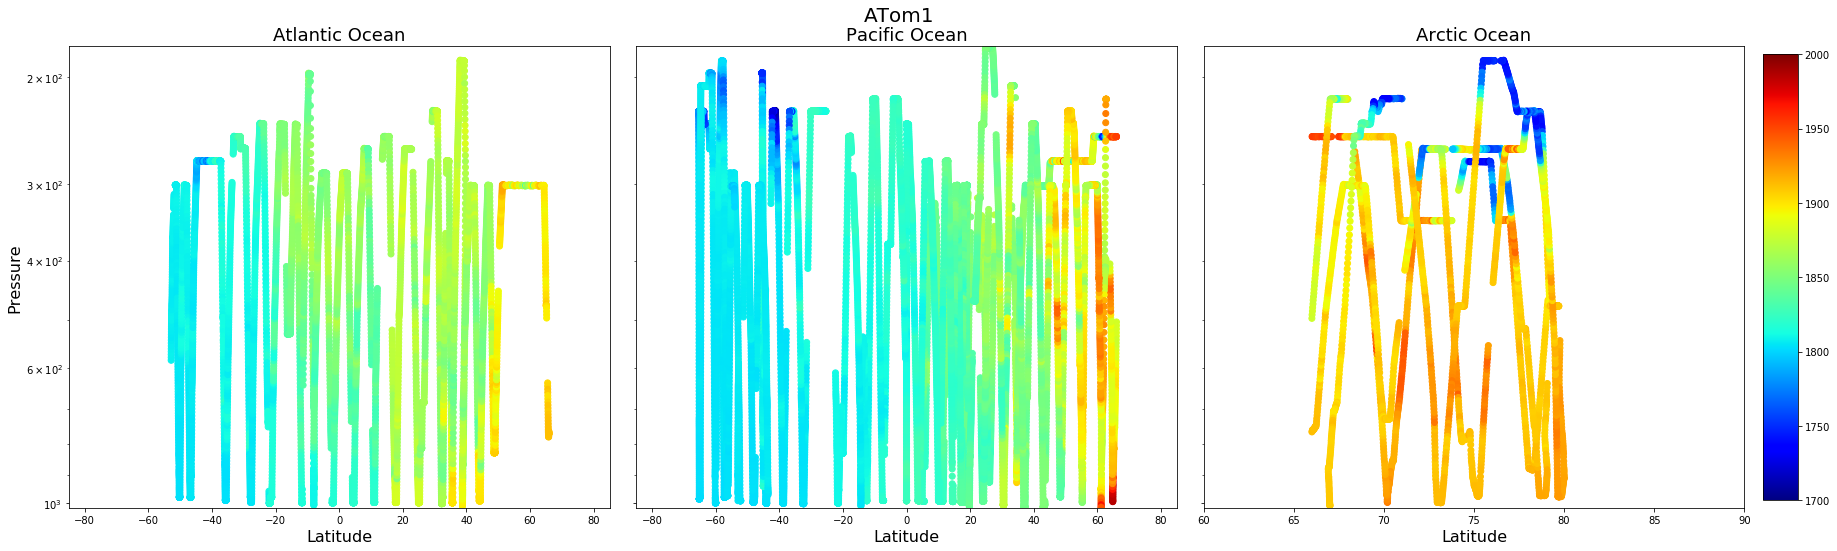

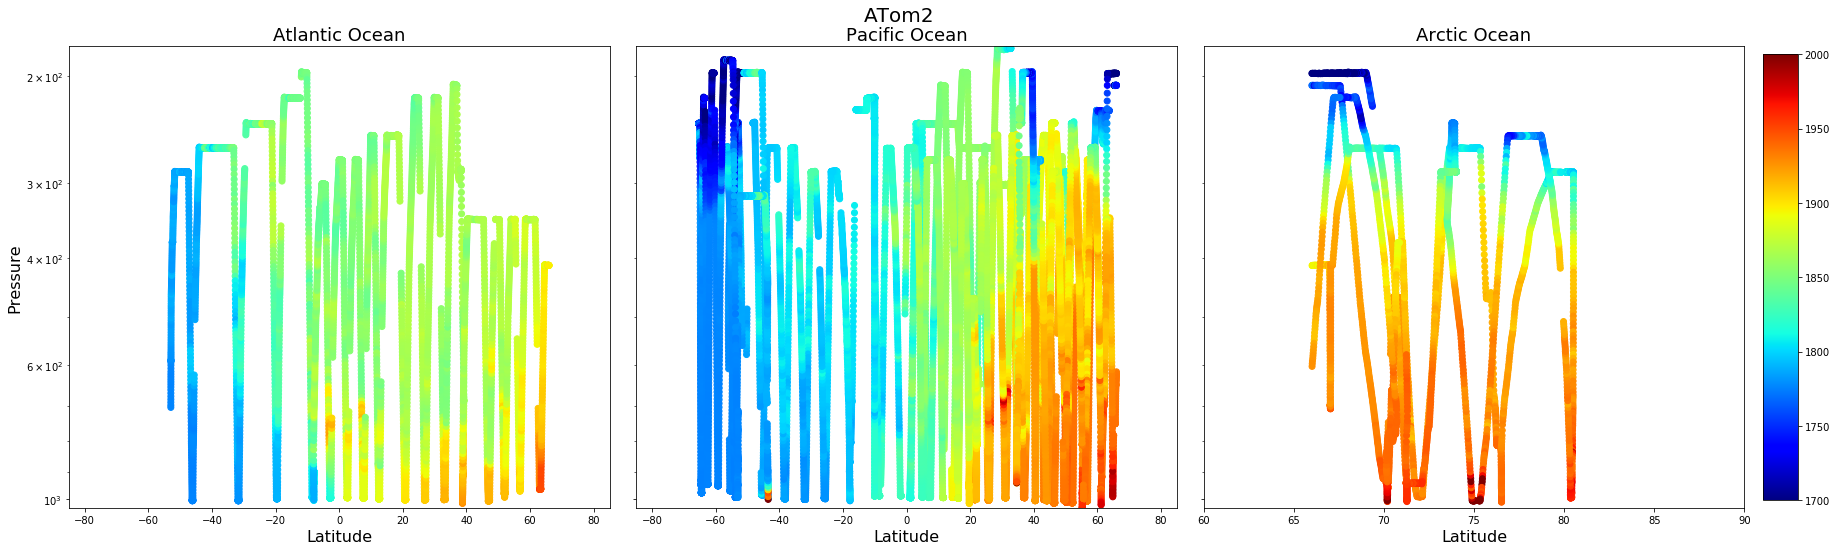

In [6]:
mr = 'M45'
data = pf_tot[mr][(pf_tot[mr]['OBS'] > 0) & (pf_tot[mr]['TYPE'] == 'ATom1')]
fig, ax = curtains.absolute_curtain(data, 'OBS')
plt.suptitle('ATom1', fontsize=20, y=1.05)

data = pf_tot[mr][(pf_tot[mr]['OBS'] > 0) & (pf_tot[mr]['TYPE'] == 'ATom2')]
fig, ax = curtains.absolute_curtain(data, 'OBS')
plt.suptitle('ATom2', fontsize=20, y=1.05)

### Stratosphere vs. Troposphere
Ensure that the stratosphere is properly identified.

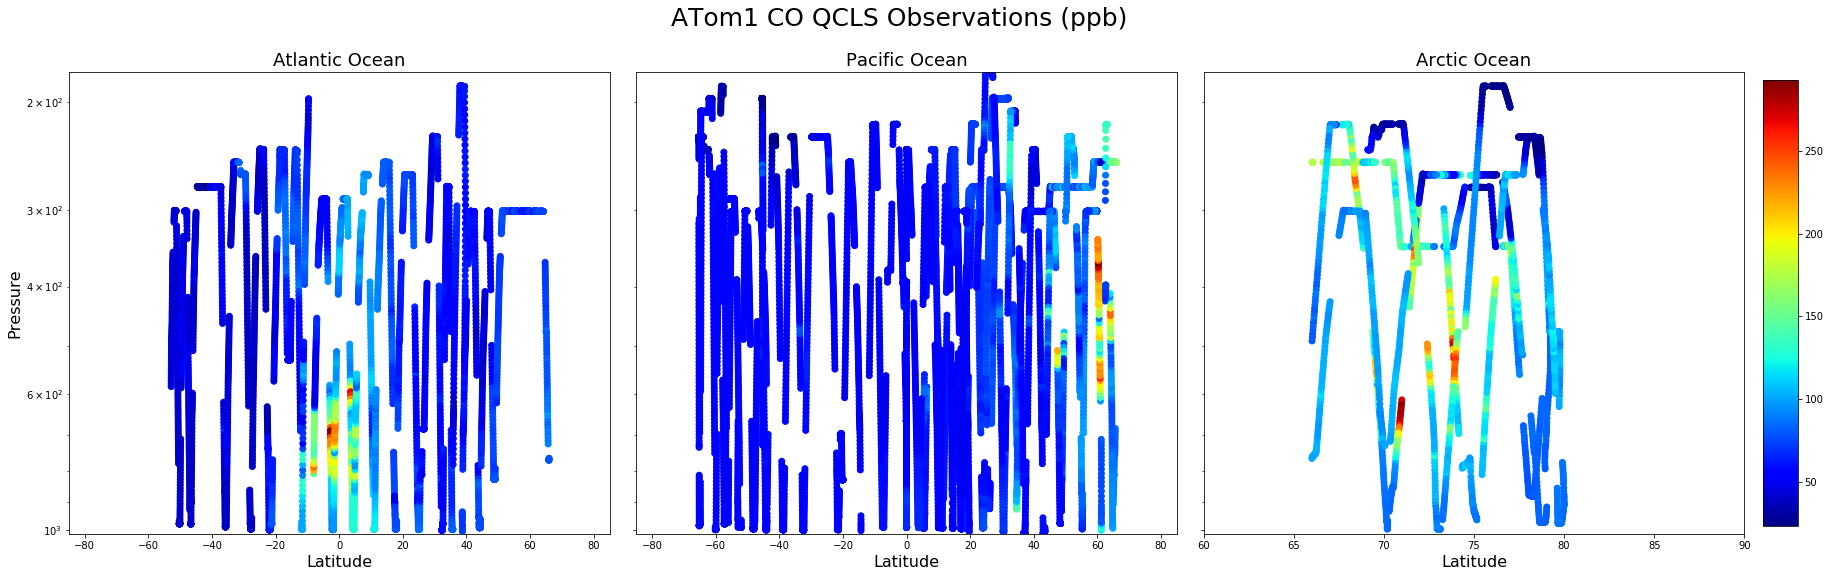

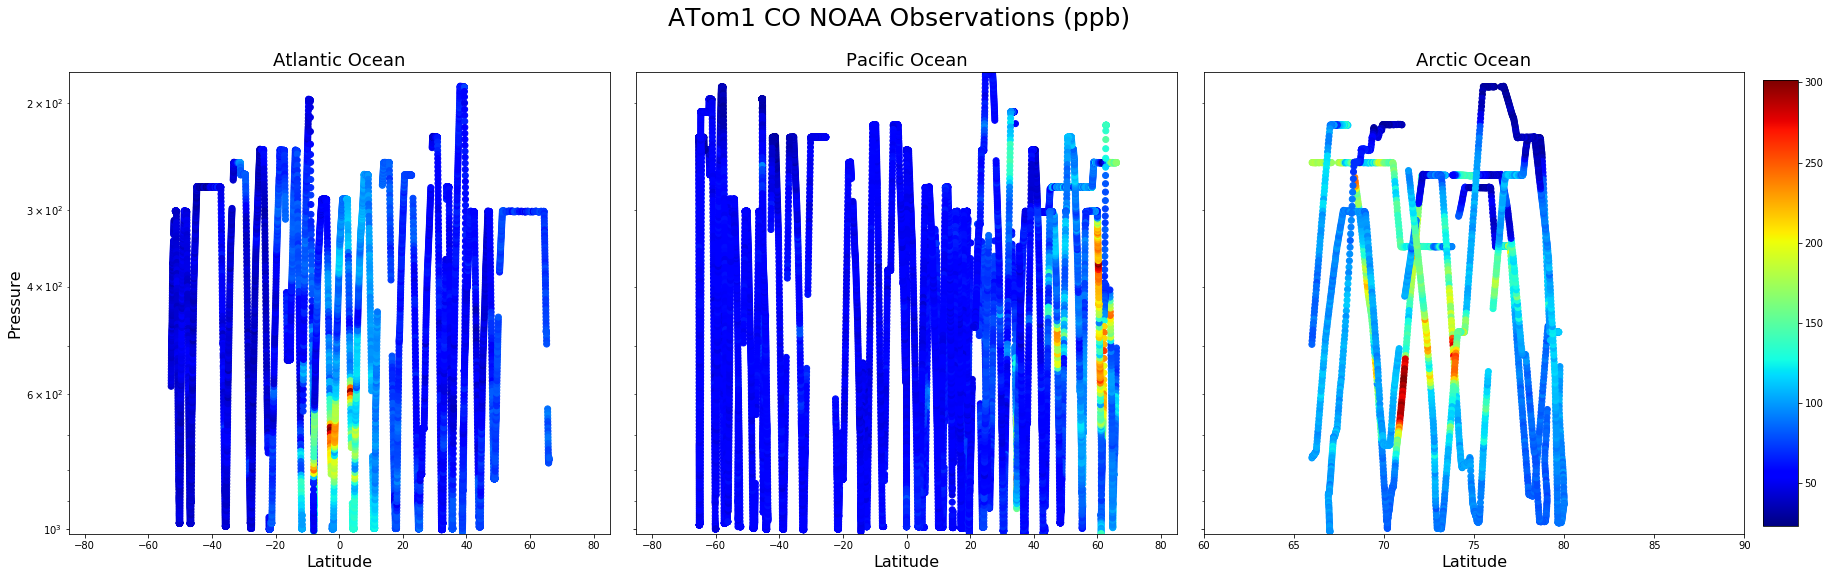

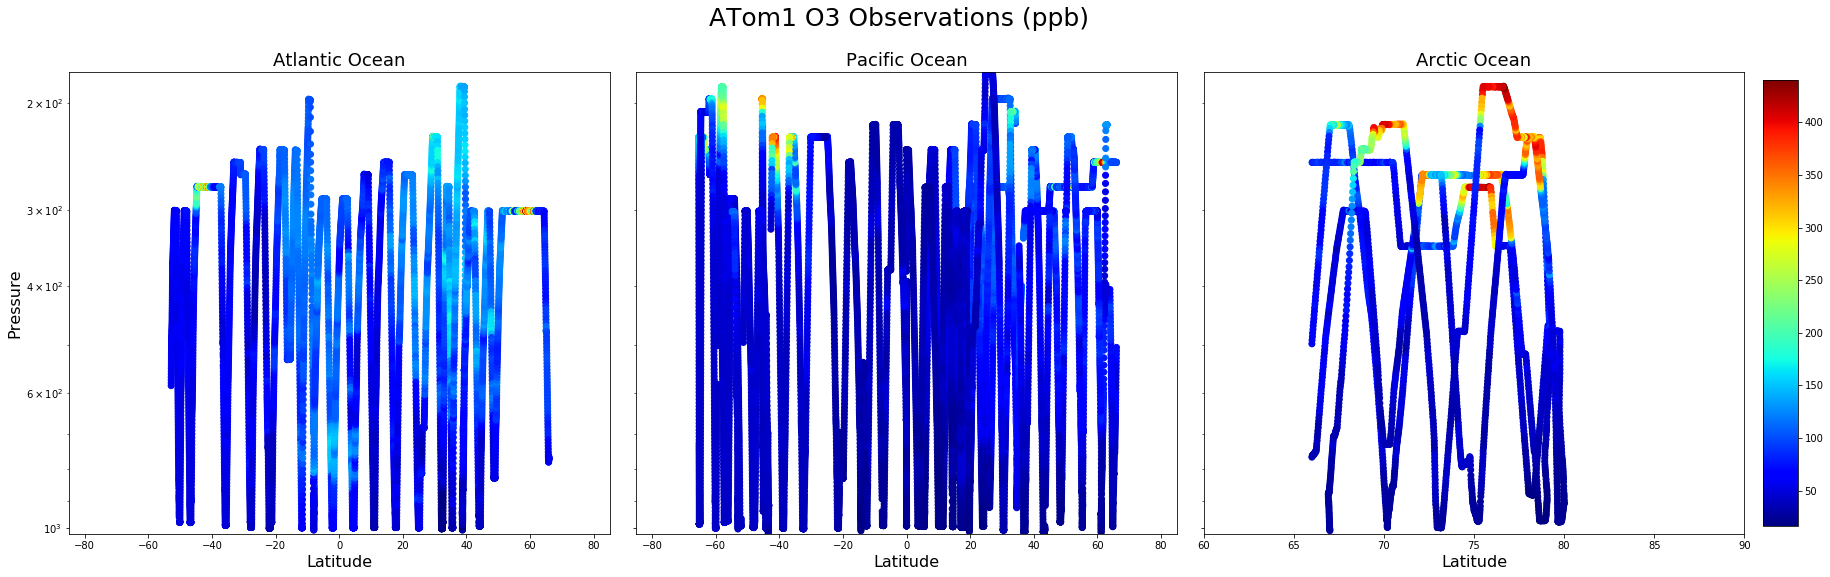

In [7]:
mr = 'M45'
data = pf_tot[mr][((pf_tot[mr]['TYPE'] == 'ATom1')
                 & (pf_tot[mr]['CO_QCLS'] > 0))]
fig, ax = curtains.basic_curtain(data, 'CO_QCLS')
plt.suptitle('ATom1 CO QCLS Observations (ppb)', fontsize=25, y=1.1)

data = pf_tot[mr][((pf_tot[mr]['TYPE'] == 'ATom1')
                 & (pf_tot[mr]['CO_NOAA'] > 0))]
fig, ax = curtains.basic_curtain(data, 'CO_NOAA')
plt.suptitle('ATom1 CO NOAA Observations (ppb)', fontsize=25, y=1.1)

data = pf_tot[mr][((pf_tot[mr]['TYPE'] == 'ATom1')
                 & (pf_tot[mr]['O3'] > 0))]
fig, ax = curtains.basic_curtain(data, 'O3')
plt.suptitle('ATom1 O3 Observations (ppb)', fontsize=25, y=1.1);

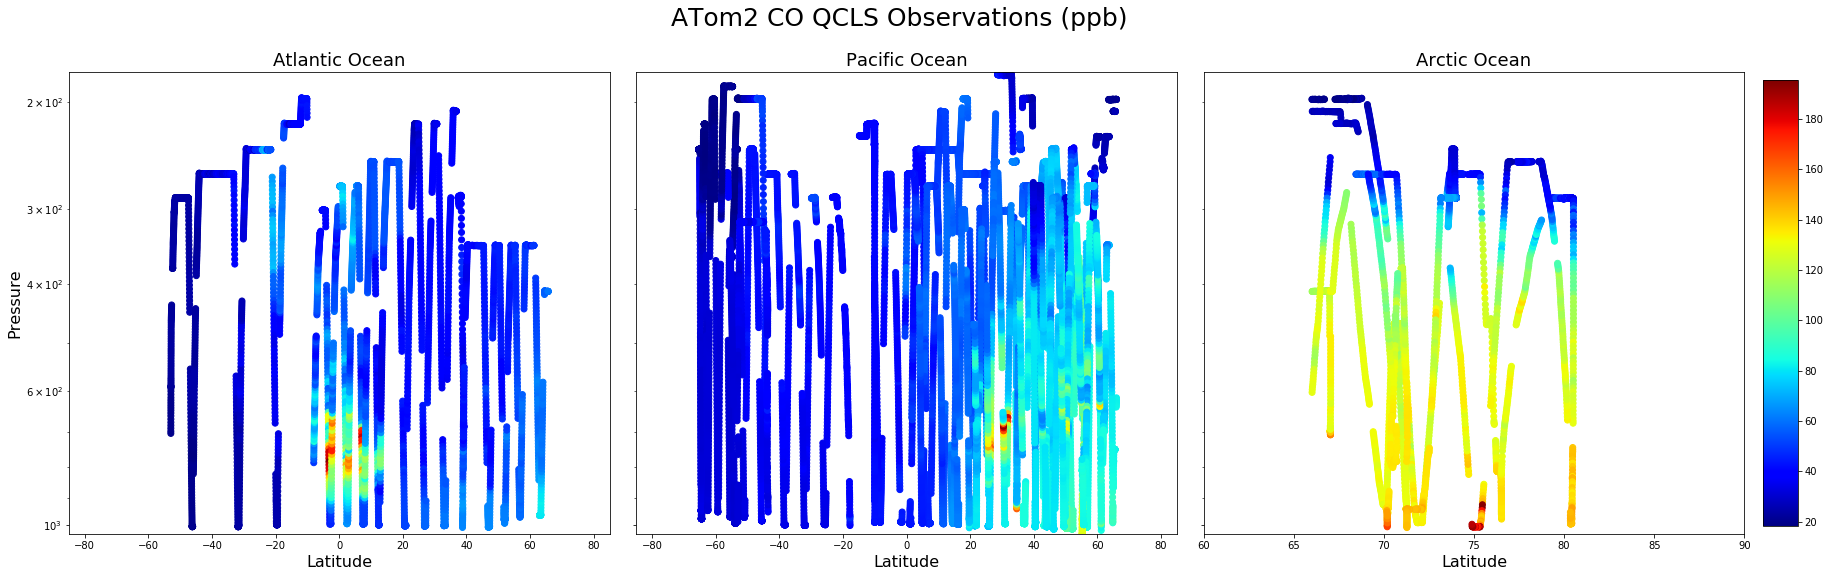

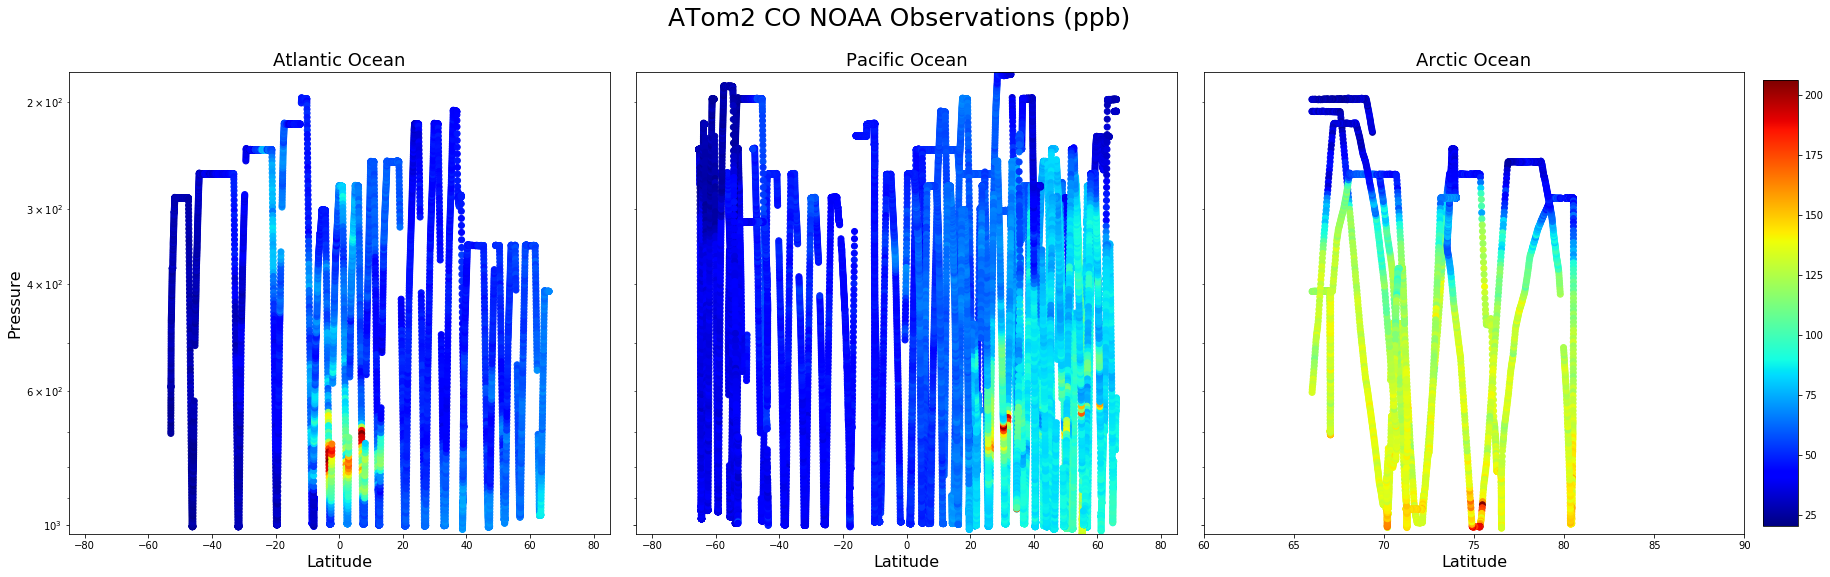

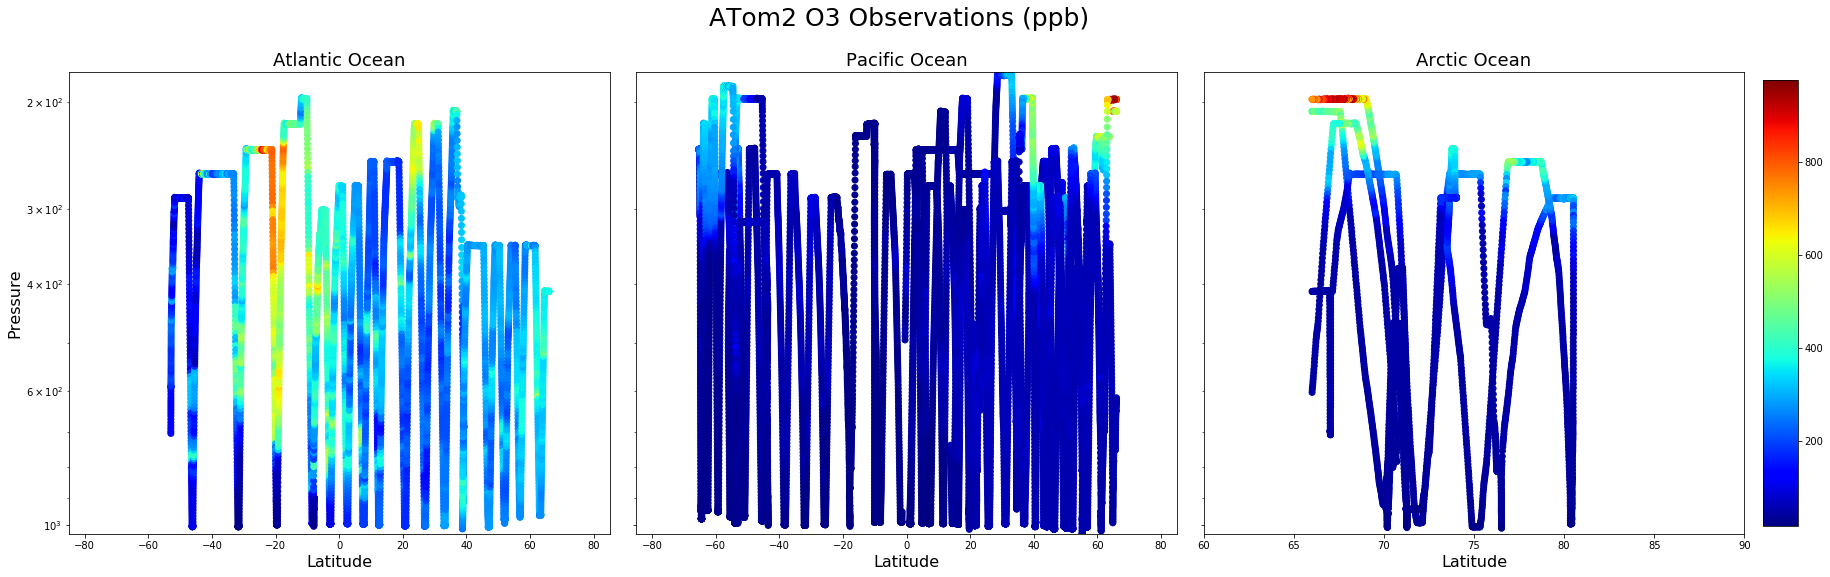

In [8]:
mr = 'M45'
data = pf_tot[mr][((pf_tot[mr]['TYPE'] == 'ATom2')
                 & (pf_tot[mr]['CO_QCLS'] > 0))]
fig, ax = curtains.basic_curtain(data, 'CO_QCLS')
plt.suptitle('ATom2 CO QCLS Observations (ppb)', fontsize=25, y=1.1)

data = pf_tot[mr][((pf_tot[mr]['TYPE'] == 'ATom2')
                 & (pf_tot[mr]['CO_NOAA'] > 0))]
fig, ax = curtains.basic_curtain(data, 'CO_NOAA')
plt.suptitle('ATom2 CO NOAA Observations (ppb)', fontsize=25, y=1.1)

data = pf_tot[mr][((pf_tot[mr]['TYPE'] == 'ATom2')
                 & (pf_tot[mr]['O3'] > 0))]
fig, ax = curtains.basic_curtain(data, 'O3')
plt.suptitle('ATom2 O3 Observations (ppb)', fontsize=25, y=1.1);

O3 observations are pretty complete. CO NOAA observations are more complete than the CO QCLS observations. But are they better?

In [9]:
# fig, ax = ss.plot_CO(data=pf_tot[mr])

In [10]:
# Bias between NOAA and QCLS data: Treat the QCLS observations as truth.
fill_co = pf_tot[mr][(pf_tot[mr]['CO_QCLS'] > 0) | (pf_tot[mr]['CO_NOAA'] > 0)].copy()
co_bias = basic_funcs.calc_bias(fill_co, 'CO_NOAA', 'CO_QCLS')
print(co_bias)

2.644502372926674


In [11]:
# Correct bias in NOAA observations
fill_co.loc[fill_co['CO_NOAA'] > 0, 'CO_NOAA_CORR'] = fill_co[fill_co['CO_NOAA'] > 0]['CO_NOAA'] - co_bias

In [12]:
# Smooth NOAA observations with a rolling average
fill_co.loc[fill_co['CO_NOAA_CORR'] > 0, 'CO_NOAA_CMA'] = fill_co[fill_co['CO_NOAA_CORR'] > 0]['CO_NOAA_CORR'].rolling(window=6, center=True).mean()

In [13]:
## Plot filled data
# fig, ax = ss.plot_CO(fill_co, ['CO_QCLS', 'CO_NOAA', 'CO_NOAA_CMA'])

In [14]:
# # Check on residual bias
# fill_co.loc[(fill_co['CO_QCLS'] > 0) & (fill_co['CO_NOAA_CMA'] > 0),
#             'RESID'] = fill_co[(fill_co['CO_QCLS'] > 0) & (fill_co['CO_NOAA_CMA'] > 0)]['CO_NOAA_CMA']\
#                        - fill_co[(fill_co['CO_QCLS'] > 0) & (fill_co['CO_NOAA_CMA'] > 0)]['CO_QCLS']
# residual_bias = np.nanmean(fill_co['RESID'])
# print(residual_bias)
# fig, ax = ss.plot_CO(fill_co, ['RESID'])

In [15]:
# Create a filled CO vector
fill_co.loc[fill_co['CO_QCLS'] <= 0, 'CO_QCLS_FILL'] = fill_co[fill_co['CO_QCLS'] <= 0]['CO_NOAA_CMA']
fill_co.loc[fill_co['CO_QCLS'] > 0, 'CO_QCLS_FILL'] = fill_co[fill_co['CO_QCLS'] > 0]['CO_QCLS']
for mr, mr_data in pf_tot.items():
     pf_tot[mr].loc[((pf_tot[mr]['CO_QCLS'] > 0) | (pf_tot[mr]['CO_NOAA'] > 0)), 'CO_QCLS_FILL'] = fill_co['CO_QCLS_FILL']

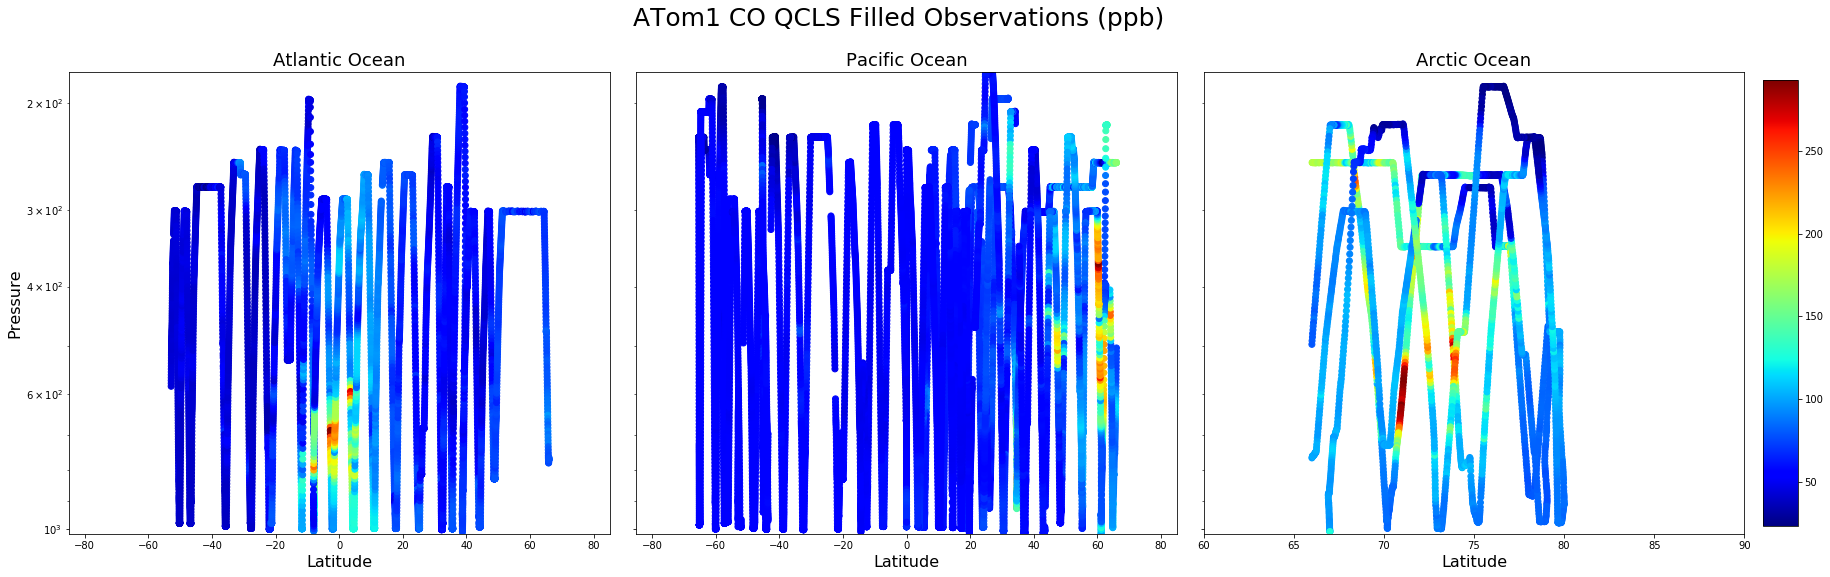

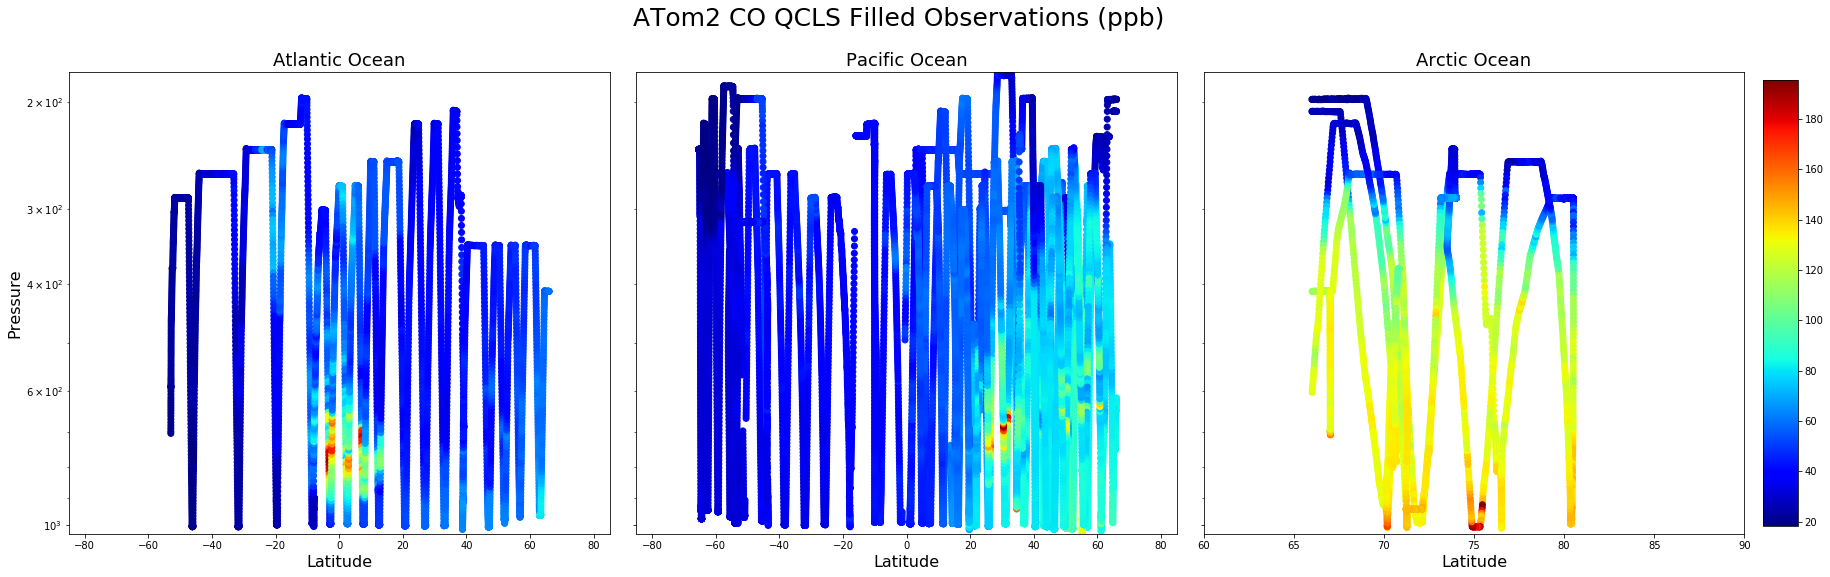

In [16]:
mr = 'M45'

data = pf_tot[mr][((pf_tot[mr]['TYPE'] == 'ATom1')
                 & (pf_tot[mr]['CO_QCLS_FILL'] > 0))]
fig, ax = curtains.basic_curtain(data, 'CO_QCLS_FILL')
plt.suptitle('ATom1 CO QCLS Filled Observations (ppb)', fontsize=25, y=1.1);

data = pf_tot[mr][((pf_tot[mr]['TYPE'] == 'ATom2')
                 & (pf_tot[mr]['CO_QCLS_FILL'] > 0))]
fig, ax = curtains.basic_curtain(data, 'CO_QCLS_FILL')
plt.suptitle('ATom2 CO QCLS Filled Observations (ppb)', fontsize=25, y=1.1);

In [17]:
for mr, mr_data in pf_tot.items():
    pf_tot[mr]['CO_O3_RAT'] = pf_tot[mr]['O3']/pf_tot[mr]['CO_QCLS_FILL']

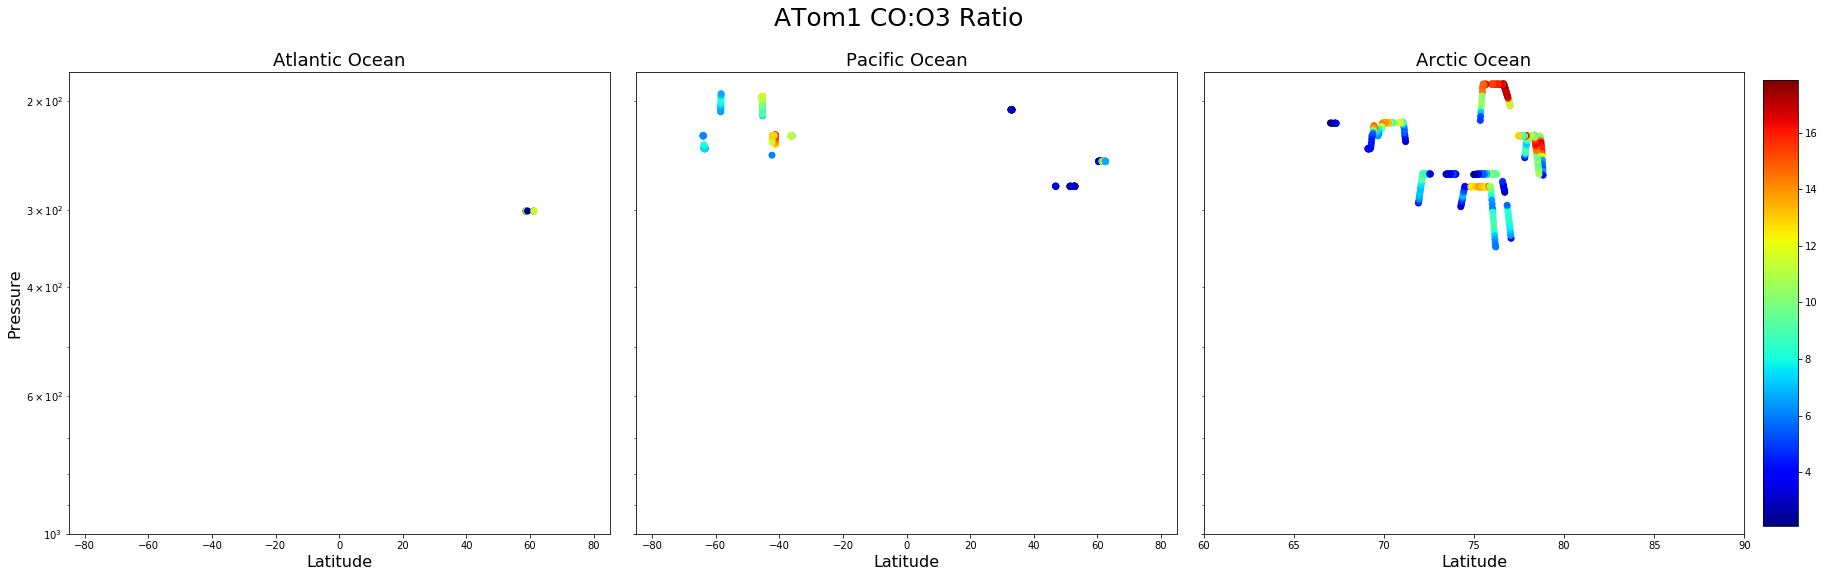

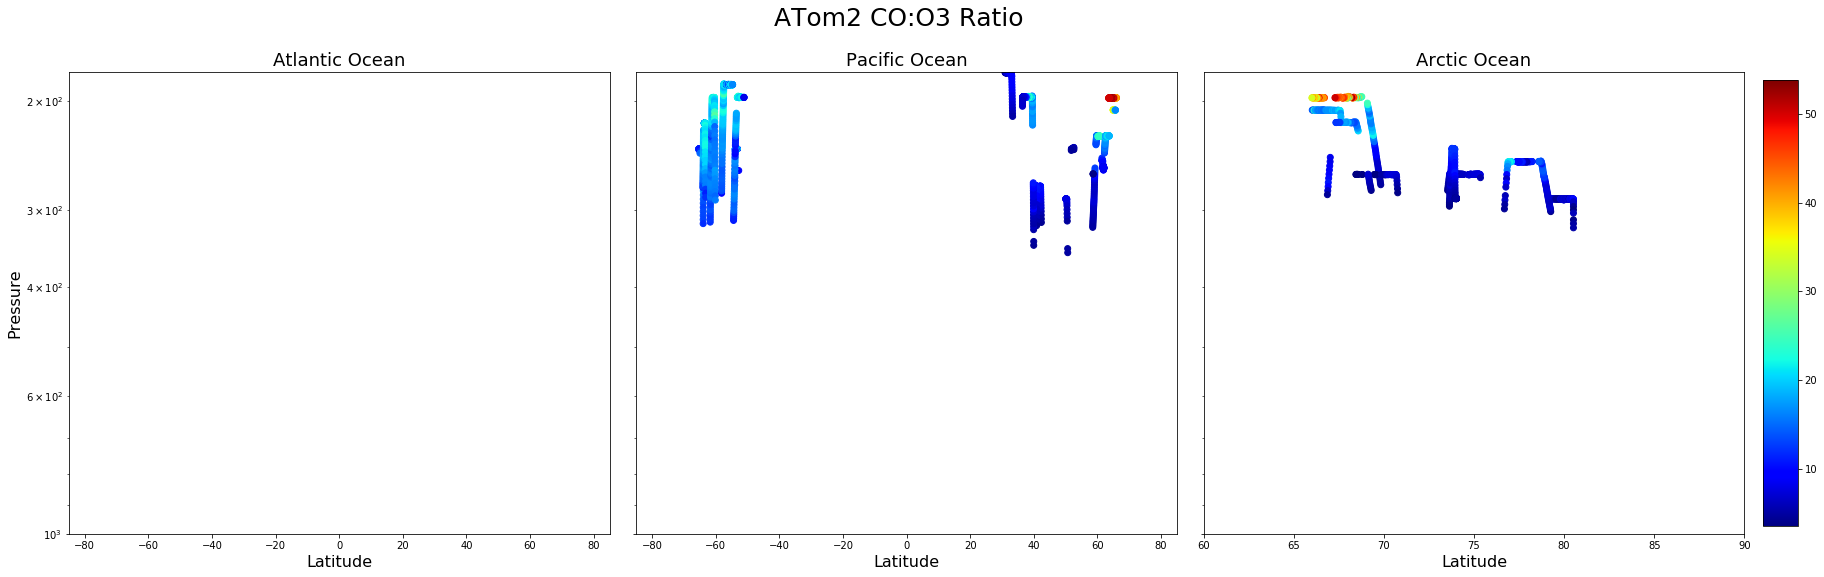

In [18]:
mr = 'M45'

data = pf_tot[mr][((pf_tot[mr]['TYPE'] == 'ATom1')
                 & (pf_tot[mr]['CO_QCLS'] > 0)
                  & (pf_tot[mr]['O3'] > 200)
                 & (pf_tot[mr]['CO_O3_RAT'] > 1.25))]
fig, ax = curtains.basic_curtain(data, 'CO_O3_RAT')
ax[0].set_ylim(1000, 180)
plt.suptitle('ATom1 CO:O3 Ratio', fontsize=25, y=1.1)

data = pf_tot[mr][((pf_tot[mr]['TYPE'] == 'ATom2')
                 & (pf_tot[mr]['CO_QCLS'] > 0)
                  & (pf_tot[mr]['O3'] > 200)
                 & (pf_tot[mr]['CO_O3_RAT'] > 1.25))]
fig, ax = curtains.basic_curtain(data, 'CO_O3_RAT')
ax[0].set_ylim(1000, 180)
plt.suptitle('ATom2 CO:O3 Ratio', fontsize=25, y=1.1);

In [19]:
for mr, mr_data in pf_tot.items():
    # Define troposphere
    pf_tot[mr]['TROP_OBS'] = True
    pf_tot[mr].loc[((pf_tot[mr]['CO_O3_RAT'] > 1.25)
                   & (pf_tot[mr]['O3'] > 150)), 
                  'TROP_OBS'] = False
    
    # Average over geoschem grid boxes
    pf_tot[mr] = basic_funcs.avg_gc_grid(pf_tot[mr], 'OBS')

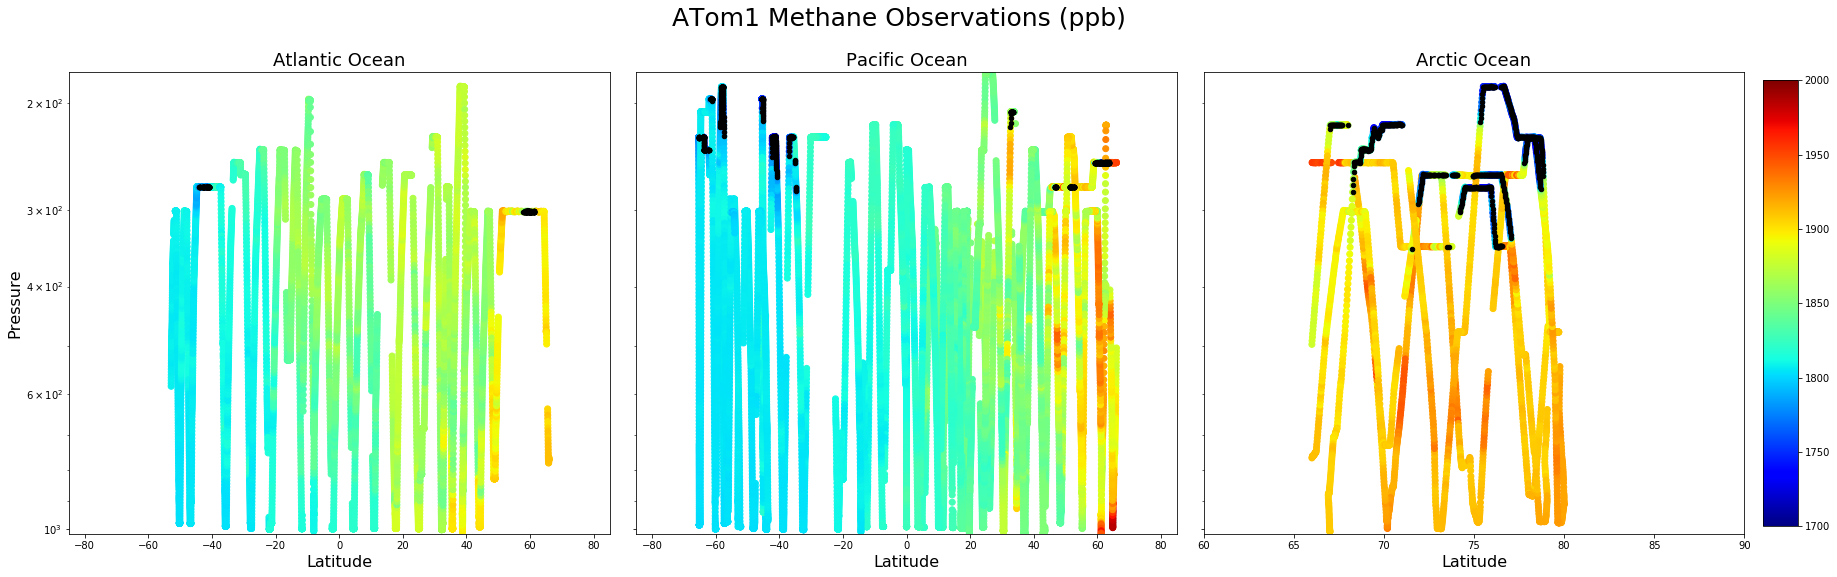

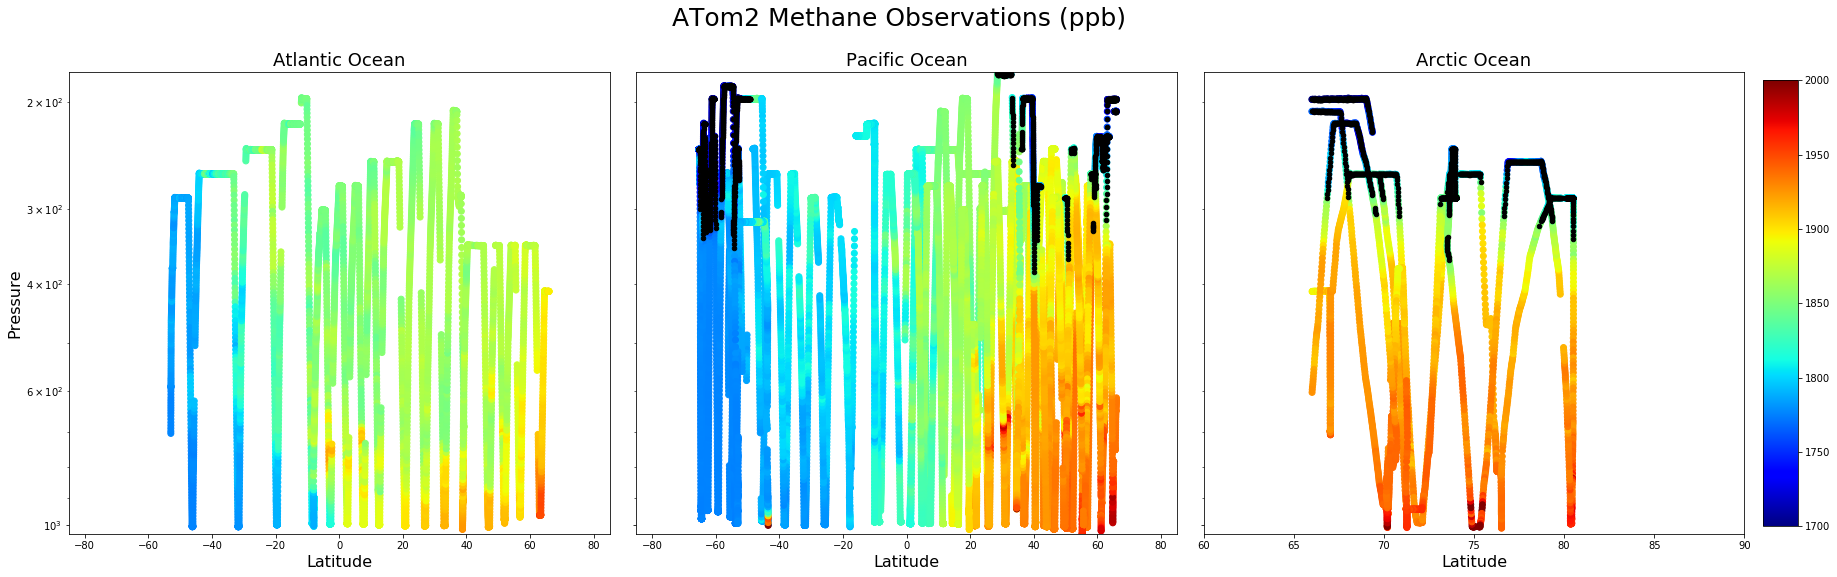

In [20]:
mr = 'M45'

data = pf_tot[mr][((pf_tot[mr]['TYPE'] == 'ATom1')
                  & (pf_tot[mr]['OBS'] > 0))]
fig, ax = curtains.absolute_curtain(data, 'OBS')
for i, ocean in enumerate(['ATL', 'PAC', 'ARC']):
    data_ocean = data[(data['OCEAN']==ocean) & ~data['TROP_OBS']]
    ax[i].scatter(data_ocean['LAT'], data_ocean['PRESS'], s=20, c='black')
plt.suptitle('ATom1 Methane Observations (ppb)', fontsize=25, y=1.1)

data = pf_tot[mr][((pf_tot[mr]['TYPE'] == 'ATom2')
                  & (pf_tot[mr]['OBS'] > 0))]
fig, ax = curtains.absolute_curtain(data, 'OBS')
for i, ocean in enumerate(['ATL', 'PAC', 'ARC']):
    data_ocean = data[(data['OCEAN']==ocean) & ~data['TROP_OBS']]
    ax[i].scatter(data_ocean['LAT'], data_ocean['PRESS'], s=20, c='black')
plt.suptitle('ATom2 Methane Observations (ppb)', fontsize=25, y=1.1);

In [21]:
# Average over 4x5 grid boxes for 2x2.5 simulation.
idx_45 = pf_tot['M45'][['YYYYMMDD', 'POINT', 'I-IND', 'J-IND']]
pf_tot['M225'] = pf_tot['M225'].drop(columns=['I-IND', 'J-IND', 'OBS_AVG'])
pf_tot['M225'] = pd.merge(left=pf_tot['M225'], right=idx_45,
                   how='left', on=['YYYYMMDD', 'POINT'])

pf_tot['M225'] = basic_funcs.avg_gc_grid(pf_tot['M225'], 'OBS')
pf_tot['M225'] = basic_funcs.avg_gc_grid(pf_tot['M225'], 'MOD')
pf_tot['M225'] = pf_tot['M225'].rename(columns={'MOD' : 'MOD_225',
                                      'MOD_AVG': 'MOD'})

In [22]:
# Now that the averages are final, create a DIFF column that is MOD-OBS_AVG
for mr, mr_data in pf_tot.items():
    pf_tot[mr]['DIFF'] = mr_data['MOD'] - mr_data['OBS_AVG']

### Array Creation
Create arrays where the methane data is non-zero (ie where measurements exist). Create separate arrays for ATom and NOAA measurements.

In [23]:
at_tot = {}
noaa_tot = {}
pf_short = {}
for mr, mr_data in pf_tot.items():
    temp = mr_data.loc[(mr_data['TROP_OBS'] 
#                      # Replace this once I figure out a better way to handle
#                      # the stratosphere--this eliminates some 6,000 data points
#                      # needlessly.
                     & pf_tot['M225']['TROP_MOD']
                     & pf_tot['M45']['TROP_MOD']
                     & pf_tot['G45']['TROP_MOD']
#                      & mr_data['TROP_MOD']
                     & (mr_data['OBS'] != 0))].copy()
    pf_short[mr] = temp
    
    temp = temp.loc[temp['TYPE'].str.slice(0,4) == 'ATom'].copy()
    temp = temp.reset_index(drop=True)
    at_tot[mr] = temp
    
    temp = mr_data.loc[mr_data['TYPE'].str.slice(0,4) != 'ATom'].copy()
    temp = temp.reset_index(drop=True)
    noaa_tot[mr] = temp

### Label Vertical Profiles

In [24]:
for mr, mr_data in at_tot.items():
    # Label vertical profiles in the ATom data
    at_tot[mr] = vp.label_vprofs(at_tot[mr], rolling_avg_window=30, threshold=12)
    
    # Remove segmented profiles (ie incorrectly identified profiles)
    at_tot[mr] = vp.remove_segmented_profs(at_tot[mr], label_column='LAB', threshold=50)
    
    # Remove profiles from take-off and landing
    at_tot[mr] = vp.remove_takeoff_landing(at_tot[mr], label_column='LAB', time_threshold_hr=2)
    
    # Reset indices
    at_tot[mr] = vp.reset_vprof_count(at_tot[mr], label_column='LAB')
    
    # Share those labels with the short planeflight files
    pf_short[mr]['LAB'] = 0
    pf_short[mr].loc[pf_short[mr]['TYPE'].str.slice(0,4) == 'ATom', 'LAB'] = at_tot[mr]['LAB']
    
    # Print out number of profiles
    print('-------------------------------')
    print('Model Run = ', mr)
    print('Number of Profiles:  ', at_tot[mr]['LAB'].max())

/Users/hannahnesser/Documents/Harvard/Research/Python/vert_profs.py:35: RuntimeWarning: invalid value encountered in greater
  if (np.all(diff_mov_avg[j:j+threshold] > 0) | np.all(diff_mov_avg[j:j+threshold] < 0)):
/Users/hannahnesser/Documents/Harvard/Research/Python/vert_profs.py:35: RuntimeWarning: invalid value encountered in less
  if (np.all(diff_mov_avg[j:j+threshold] > 0) | np.all(diff_mov_avg[j:j+threshold] < 0)):


-------------------------------
Model Run =  M225
Number of Profiles:   254
-------------------------------
Model Run =  M45
Number of Profiles:   254
-------------------------------
Model Run =  G45
Number of Profiles:   254


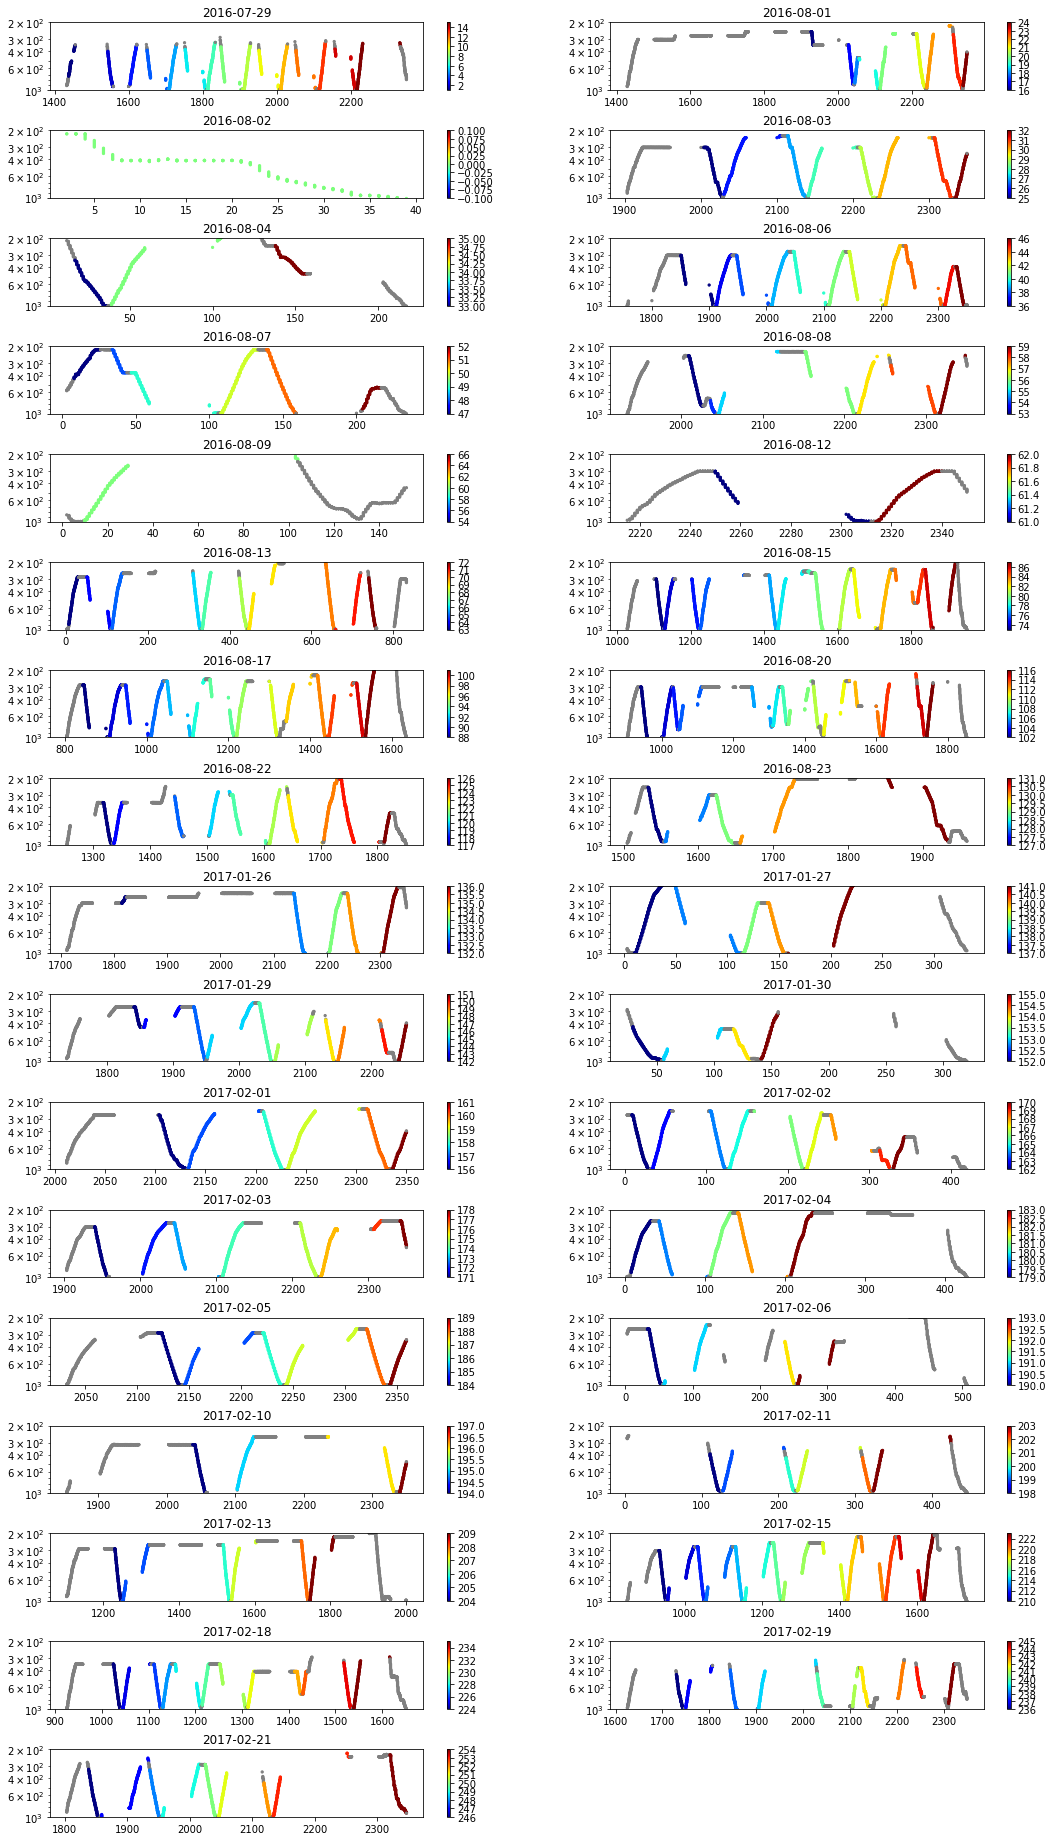

In [25]:
mr = 'M225'
vp.plot_profiles(at_tot[mr], label_column='LAB');
# vp.plot_profiles(at_tot[0], label_column='PROF');

### Total Column Calculations
Calculate the total column concentrations for each vertical profile.

In [26]:
# create pressure bands:
pressure_bands = np.linspace(300, at_tot['M225']['PRESS'].max(), 6)

at_cols = {}
for mr, mr_data in at_tot.items():
    at_cols[mr] = tc.calc_tot_cols(at_tot[mr], pressure_bands=pressure_bands)

### Final Array Creation

In [27]:
# We wish to create summary arrays that summarize the difference between observations
# and different model runs.
at_cols_summ = bias.build_summary_df(at_cols)
at_cols_summ = at_cols_summ.dropna(axis='index')

In [28]:
# Do the same with NOAA data.
noaa_rem = {}
for mr, mr_data in noaa_tot.items():
    noaa_rem[mr] = mr_data[mr_data['REM']]

noaa_summ = bias.build_summary_df(noaa_rem)

In [29]:
at_cols_summ.head()

TYPE  LAB    YYYYMMDD  HHMM OCEAN        LAT       LON          OBS  \
0  ATom1    2  2016-07-29  1544   PAC  26.673736 -120.5200  1842.459319   
1  ATom1    4  2016-07-29  1650   PAC  19.155341 -120.5200  1844.507184   
2  ATom1    5  2016-07-29  1710   PAC  17.190085 -120.5200  1840.129101   
3  ATom1    6  2016-07-29  1753   PAC  12.014778 -120.5200  1839.137257   
4  ATom1    7  2016-07-29  1813   PAC  10.074960 -120.5316  1834.629202   

       OBS_AVG         M225          M45          G45  M225_OBS   M45_OBS  \
0  1843.887747  1849.960267  1844.809738  1844.427810  6.072520  0.909158   
1  1843.082645  1848.395074  1842.508261  1839.668261  5.312430 -0.574384   
2  1841.187986  1847.544901  1841.791667  1839.136667  6.356915  0.586858   
3  1838.891918  1840.688205  1834.399048  1833.276667  1.796287 -4.490605   
4  1836.343731  1839.360967  1827.045311  1828.178449  3.017236 -9.298907   

    G45_OBS   M225_M45   G45_M45  
0  0.590397   5.163362 -0.318761  
1 -3.414384   5.886813 -2.840000  
2 -2.068142   5.770058 -2.655000  
3 -5.618731   6.286892 -1.128126  
4 -8.165282  12.316143  1.133626

## Bias Analysis

### Latitudinal Bands

In [30]:
lat_bands = np.arange(-90, 91, 30)
at_cols_lat_band_means = bias.calc_band_stat(at_cols_summ, 'mean', 'LAT', lat_bands)
at_cols_lat_band_means = at_cols_lat_band_means[at_cols_lat_band_means['OCEAN'] != 'NONE']
noaa_lat_band_means = bias.calc_band_stat(noaa_summ, 'mean', 'LAT', lat_bands)

at_cols_lat_band_stds = bias.calc_band_stat(at_cols_summ, 'std', 'LAT', lat_bands)
at_cols_lat_band_stds = at_cols_lat_band_stds[at_cols_lat_band_stds['OCEAN'] != 'NONE']
noaa_lat_band_stds = bias.calc_band_stat(noaa_summ, 'std', 'LAT', lat_bands)

In [31]:
temp = at_cols_lat_band_means.dropna(axis='index')
temp[temp['TYPE'] == 'ATom1'].to_csv('ATom1_lat_band_summary.csv')
temp[temp['TYPE'] == 'ATom2'].to_csv('ATom2_lat_band_summary.csv')

temp = noaa_lat_band_means.dropna(axis='index')
temp.to_csv('NOAA_lat_band_summary.csv')


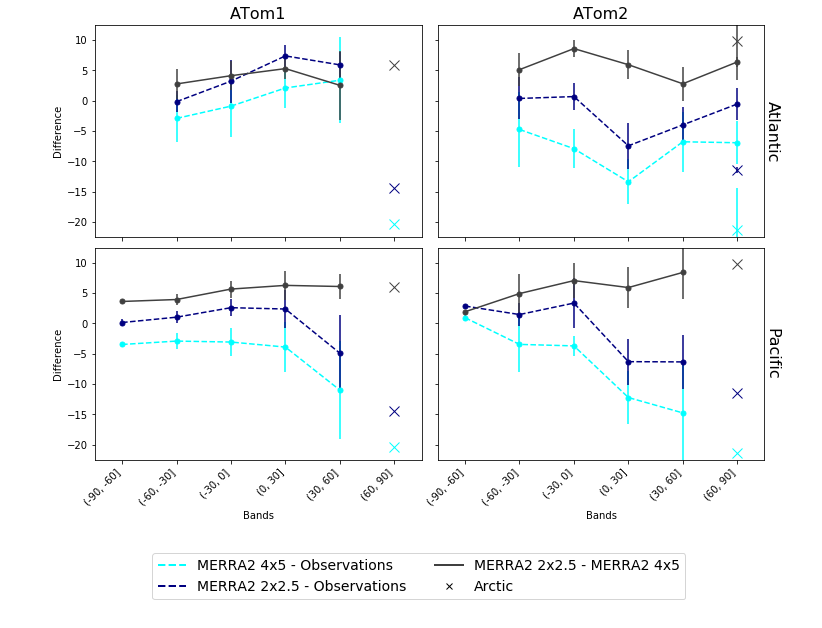

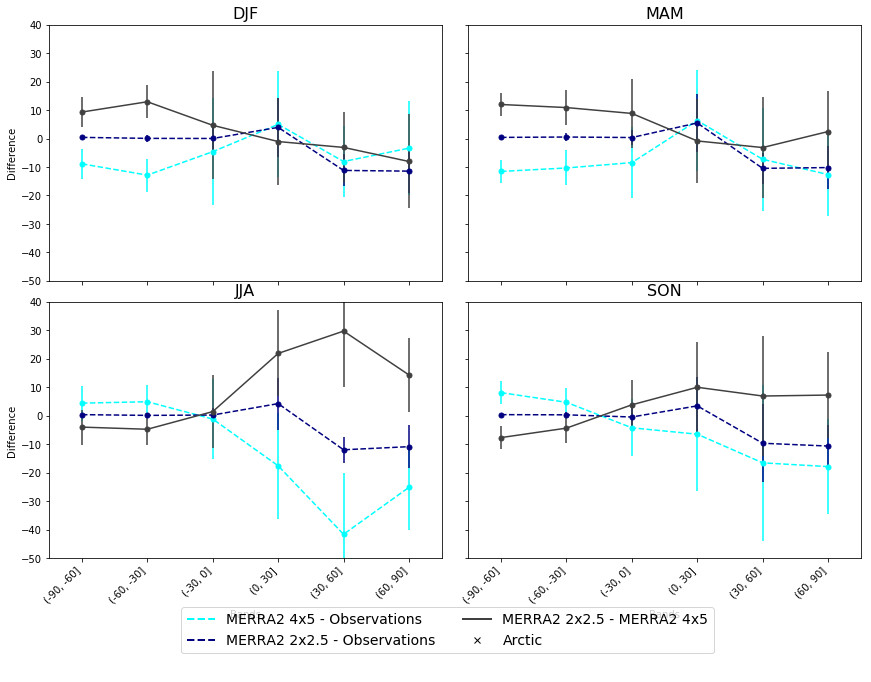

In [32]:
diff_cols = ['M45_OBS', 'M225_OBS', 'M225_M45']
colors = ['Aqua', 'Navy', '0.25']
linestyles = ['--', '--', '-']
markers = ['.', '.', '.']
markersizes = [10, 10, 10]
plot_options = {'color' : colors, 'linestyle' : linestyles, 
                'marker' : markers, 'markersize' : markersizes,
                'yerr' : at_cols_lat_band_stds}

# LEGEND
lines = [Line2D([], [], color=col, lw=2, ls=ls) 
         for col, ls 
         in zip(colors, linestyles)]
lines.append(Line2D([], [], marker='x', 
             color='w', markeredgecolor='black'))
legend_labels = ['MERRA2 4x5 - Observations',  
                 'MERRA2 2x2.5 - Observations',
                 'MERRA2 2x2.5 - MERRA2 4x5',
                 'Arctic']

## ATOM
fig, ax = bias.plot_atom_bias(at_cols_lat_band_means, 
                              bias.band_scatter,
                              diff_cols = diff_cols,
                              **plot_options)
cax = fig.add_axes([0.05, -0.125, 0.9, 0.1])
plt.axis('off')
cax.legend(lines, legend_labels, 
           fontsize=14, ncol=2, loc = 'upper center')

## NOAA
plot_options['yerr'] = noaa_lat_band_stds
fig, ax = bias.plot_noaa_bias(noaa_lat_band_means, 
                              bias.band_scatter,
                              diff_cols = diff_cols,
                              **plot_options)
cax = fig.add_axes([0.05, -0.125, 0.9, 0.1])
plt.axis('off')
cax.legend(lines, legend_labels, 
           fontsize=14, ncol=2, loc = 'upper center');

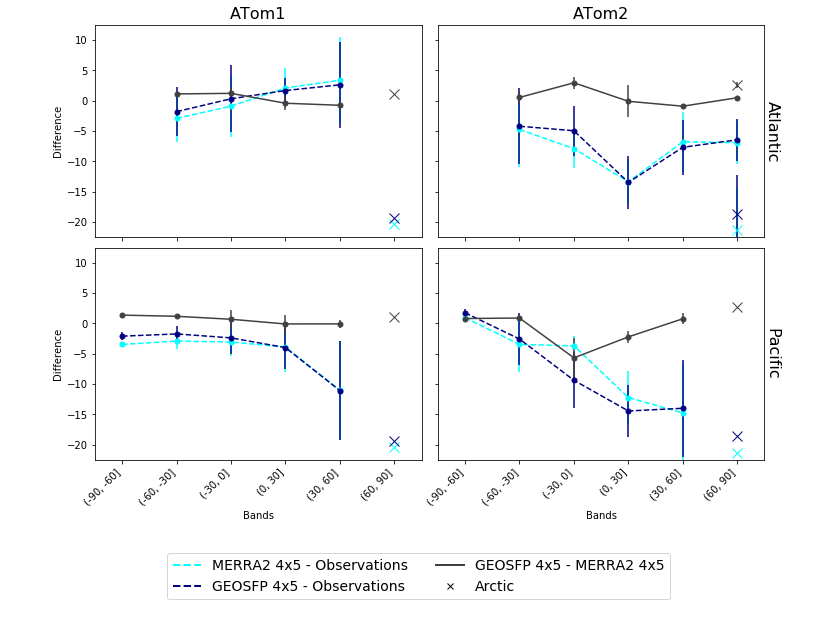

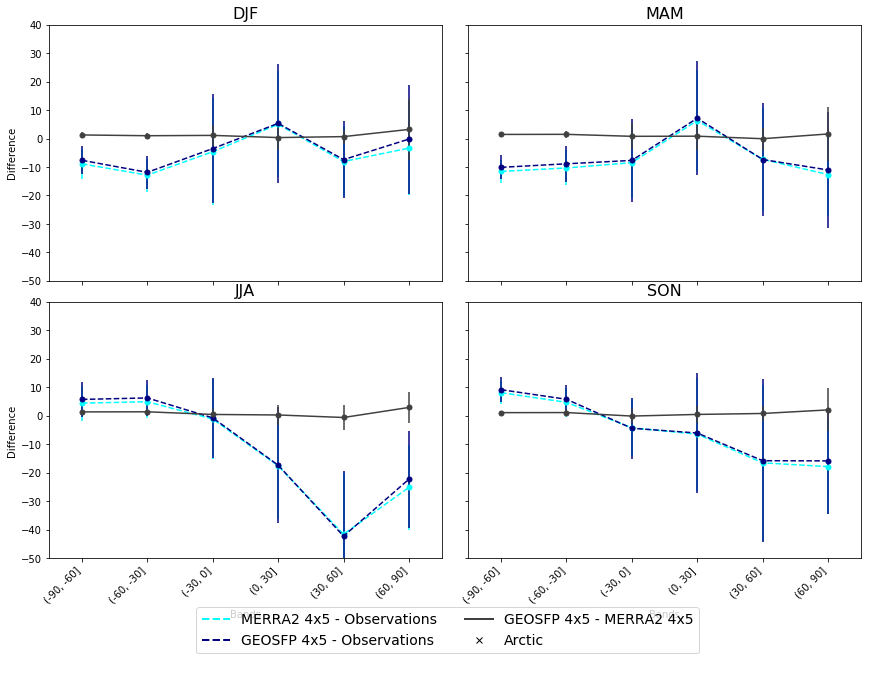

In [33]:
diff_cols = ['M45_OBS', 'G45_OBS', 'G45_M45']
colors = ['Aqua', 'Navy', '0.25']
linestyles = ['--', '--', '-']
markers = ['.', '.', '.']
markersizes = [10, 10, 10]
plot_options = {'color' : colors, 'linestyle' : linestyles, 
                'marker' : markers, 'markersize' : markersizes,
                'yerr' : at_cols_lat_band_stds}

# LEGEND
lines = [Line2D([], [], color=col, lw=2, ls=ls) 
         for col, ls 
         in zip(colors, linestyles)]
lines.append(Line2D([], [], marker='x', 
             color='w', markeredgecolor='black'))
legend_labels = ['MERRA2 4x5 - Observations',  
                 'GEOSFP 4x5 - Observations',
                 'GEOSFP 4x5 - MERRA2 4x5',
                 'Arctic']

## ATOM
fig, ax = bias.plot_atom_bias(at_cols_lat_band_means, 
                              bias.band_scatter,
                              diff_cols = diff_cols,
                              **plot_options)
cax = fig.add_axes([0.05, -0.125, 0.9, 0.1])
plt.axis('off')
cax.legend(lines, legend_labels, 
           fontsize=14, ncol=2, loc = 'upper center')

## NOAA
plot_options['yerr'] = noaa_lat_band_stds
fig, ax = bias.plot_noaa_bias(noaa_lat_band_means, 
                              bias.band_scatter,
                              diff_cols = diff_cols,
                              **plot_options)
cax = fig.add_axes([0.05, -0.125, 0.9, 0.1])
plt.axis('off')
cax.legend(lines, legend_labels, 
           fontsize=14, ncol=2, loc = 'upper center');

### Hemispheric Gradient

In [34]:
hemispheres = np.arange(-90, 91, 90)
at_cols_hemisphere_means = bias.calc_band_stat(at_cols_summ, 'mean', 'LAT', hemispheres)
at_cols_hemisphere_means = at_cols_hemisphere_means[at_cols_hemisphere_means['OCEAN'] != 'NONE']
noaa_hemisphere_means = bias.calc_band_stat(noaa_summ, 'mean', 'LAT', hemispheres)

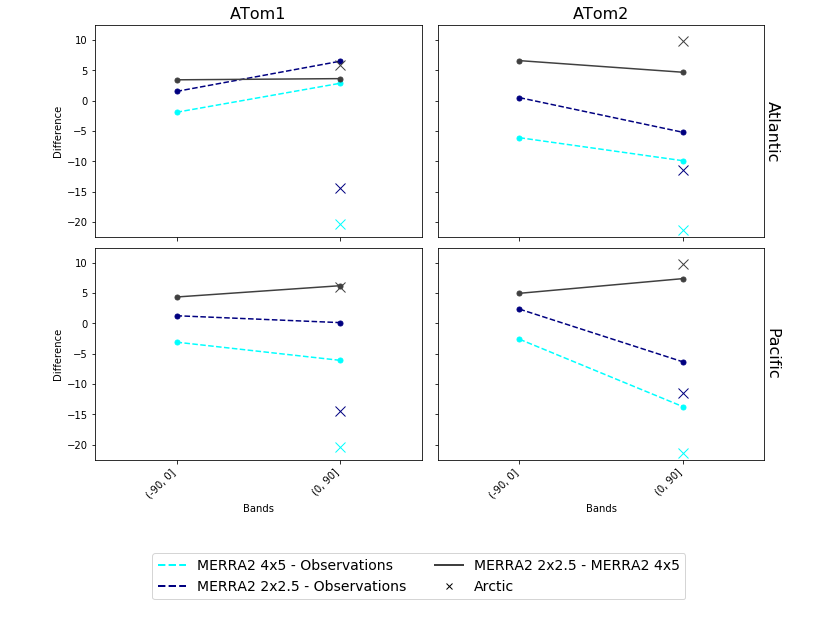

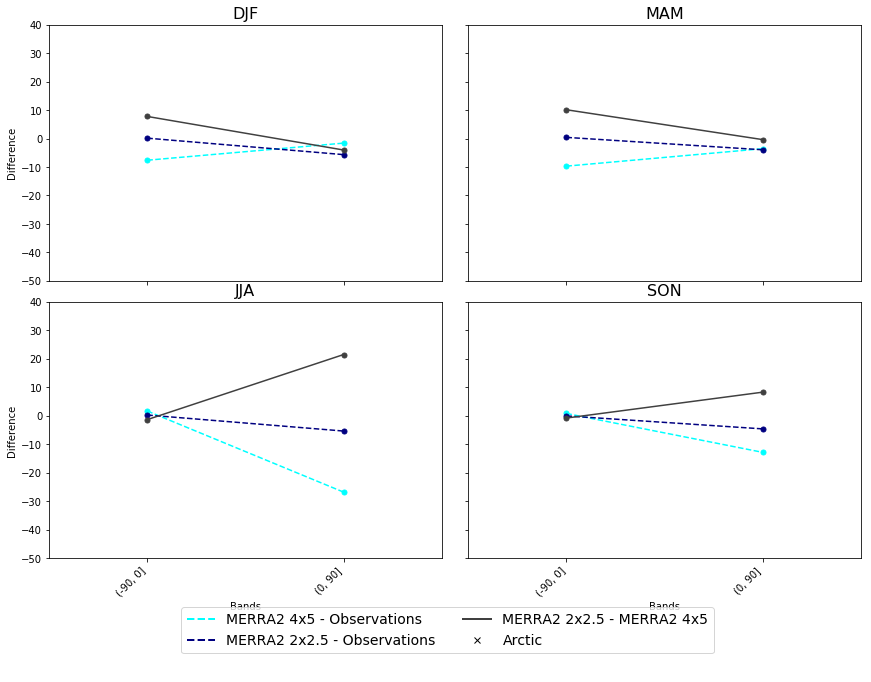

In [35]:
diff_cols = ['M45_OBS', 'M225_OBS', 'M225_M45']
colors = ['Aqua', 'Navy', '0.25']
linestyles = ['--', '--', '-']
markers = ['.', '.', '.']
markersizes = [10, 10, 10]
plot_options = {'color' : colors, 'linestyle' : linestyles, 
                'marker' : markers, 'markersize' : markersizes}

# LEGEND
lines = [Line2D([], [], color=col, lw=2, ls=ls) 
         for col, ls 
         in zip(colors, linestyles)]
lines.append(Line2D([], [], marker='x', 
             color='w', markeredgecolor='black'))
legend_labels = ['MERRA2 4x5 - Observations',  
                 'MERRA2 2x2.5 - Observations',
                 'MERRA2 2x2.5 - MERRA2 4x5',
                 'Arctic']

## ATOM
fig, ax = bias.plot_atom_bias(at_cols_hemisphere_means, 
                              bias.band_scatter,
                              diff_cols = diff_cols,
                              **plot_options)
cax = fig.add_axes([0.05, -0.125, 0.9, 0.1])
plt.axis('off')
cax.legend(lines, legend_labels, 
           fontsize=14, ncol=2, loc = 'upper center')

## NOAA
fig, ax = bias.plot_noaa_bias(noaa_hemisphere_means, 
                              bias.band_scatter,
                              diff_cols = diff_cols,
                              **plot_options)
cax = fig.add_axes([0.05, -0.125, 0.9, 0.1])
plt.axis('off')
cax.legend(lines, legend_labels, 
           fontsize=14, ncol=2, loc = 'upper center');

### Pressure Bands

In [36]:
# def calc_tot_cols(full_data, label_column='LAB', calc_partial_col=False):
#     data = full_data[[label_column, 'P-I-S', 'P-DIFF-S',
#                       'YYYYMMDD', 'HHMM', 'ATL', 'LAT', 'LON', 
#                       'OBS', 'OBS_AVG', 'MOD', 'DIFF']]
#     data = complete_vprofs(data, threshold=3, pressure_levels=6)
#     # data = vp.reset_vprof_count(data, label_column=label_column)

#     # Create the basis of the total column dataframe
#     tot_cols = data[[label_column, 'LAT', 'LON']].groupby([label_column]).mean().reset_index()
#     date_time = data[[label_column, 'YYYYMMDD', 'HHMM', 'ATL']].groupby([label_column]).min().reset_index()
#     tot_cols = pd.merge(left=date_time, right=tot_cols,
#                         how='right',
#                         on=label_column)

#     # Calculate columns
#     pavg_data = data[[label_column, 'P-I-S', 'P-DIFF-S', 'OBS', 'OBS_AVG', 'MOD', 'DIFF']]
#     pavg = pavg_data.groupby([label_column, 'P-I-S']).mean().reset_index()
#     for i, col_title in enumerate(['OBS', 'OBS_AVG', 'MOD', 'DIFF']):
#         pavg[col_title] = pavg[['P-DIFF-S']].values*pavg[[col_title]]
    
#     if calc_partial_col:
#         sums = calc_partial_cols(pavg, label_column, [0,4,6])
#     else:
#         sums = pavg.groupby([label_column]).sum().reset_index()
    
#     for i, col_title in enumerate(['OBS', 'OBS_AVG', 'MOD', 'DIFF']):
#         sums[col_title] = sums[[col_title]]/sums[['P-DIFF-S']].values
        
#     if calc_partial_col:
#         sums = sums[[label_column, 'P_BAND', 'OBS', 'OBS_AVG', 'MOD', 'DIFF']]
#     else:
#         sums = sums[[label_column, 'OBS', 'OBS_AVG', 'MOD', 'DIFF']]
    
#     # Combine
#     tot_cols = pd.merge(left=tot_cols, right=sums,
#                         how='left',
#                         on=label_column)

#     return tot_cols

# def calc_partial_cols(pavg_data, label_column, pressure_grouping):
#     # P-I-S 1-4 take us down to ~500 hPa.
#     pavg_data['P_BAND'] = pd.cut(pavg_data['P-I-S'], 
#                                  bins=[0,4,6], 
#                                  labels=['Surface - 490 hPa', '490 hPa - 288 hPa'])
#     sums = pavg_data.groupby(['LAB', 'P_BAND']).sum().reset_index()
#     return sums

# def complete_vprofs(full_data, label_column='LAB', threshold=3, pressure_levels=6):
#     data = full_data[(full_data[label_column] > 0) & (full_data['P-I-S'] > 0)]

#     # we define a complete vertical profile as one which has at least
#     # n=threshold datapoints in each of the reduced pressure levels
#     data_counts = data.groupby([label_column, 'P-I-S']).count()['YYYYMMDD'].reset_index()
#     data_counts = data_counts.rename(columns={'YYYYMMDD' : 'COUNT'})
#     data_counts = data_counts[data_counts['COUNT'] > threshold]

#     plev_counts = data_counts.groupby([label_column]).count()['COUNT'].reset_index()
#     plev_counts = plev_counts[plev_counts['COUNT'] == pressure_levels]

#     data = data[data[label_column].isin(plev_counts[label_column])]
#     return data

In [37]:
# at_partial_cols = {}
# for mr, mr_data in at_tot.items():
#     at_partial_cols[mr] = tc.calc_tot_cols(mr_data, calc_partial_col=True)

In [38]:
# at_partial_cols['M225'].head()

In [39]:
# # We wish to create summary arrays that summarize the difference between observations
# # and different model runs.
# at_partial_cols_summ = bias.build_summary_df(at_partial_cols)
# at_partial_cols_summ = at_partial_cols_summ.dropna(axis='index')
# at_partial_cols_summ.head()
# ### THIS METHOD IS WHERE THE PROBLEM IS.

In [40]:
# at_cols_press_band_stats = bias.calc_band_stats(at_cols_summ, 'P_BAND', lat_bands)

### Bias Plots
Plot GEOS-Chem methane concentrations versus ATom methane concentrations (averaged over GEOS-Chem grid boxes) globally and over each ocean.

#### ATom

In [41]:
# fig, ax = bias.plot_atom_bias(at_cols, bias.obs_mod_scatter, MODEL_RUN_NAMES)
# fig.suptitle('Modeled vs. Observed Methane Columns (ATom)', y=1.075, fontsize=16);

In [42]:
# fig, ax = bias.plot_atom_bias(at_cols, bias.lat_scatter, MODEL_RUN_NAMES)
# fig.suptitle('Methane Columns vs. Latitude (ATom)', y=1.075, fontsize=16);

In [43]:
# fig, ax = bias.plot_atom_bias(at_cols, bias.lat_diff_scatter, MODEL_RUN_NAMES)
# fig.suptitle('Model - Observations vs. Latitude (ATom)', y=1.075, fontsize=16)
# for i in range(2):
#     for j in range(3):
#         for k in range(-90,91,30):
#             ax[i,j].axvline(k, c='0.90');

In [44]:
# fig, ax = bias.plot_atom_bias(at_tot, bias.lat_diff_scatter, MODEL_RUN_NAMES)
# fig.suptitle('Model - Observations vs. Latitude (ATom)', y=1.075, fontsize=16);

#### NOAA

In [45]:
# fig, ax = bias.plot_noaa_bias(noaa_tot, bias.obs_mod_scatter, MODEL_RUN_NAMES)
# fig.suptitle('Modeled vs. Observed Methane (NOAA)', y=1.05, fontsize=16);

In [46]:
# fig, ax = bias.plot_noaa_bias(noaa_tot, bias.lat_scatter, MODEL_RUN_NAMES)
# fig.suptitle('NOAA Methane Observations vs. Latitude (NOAA)', y=1.075, fontsize=16);

### Curtains
Plot the following over the Atlantic and Pacific Oceans:
- ATom methane concentrations;
- ATom methane concentrations averaged over GEOS-Chem grid boxes;
- GEOS-Chem methane concentrations;
- The difference between the GEOS-Chem methane concentrations and the ATom concentrations (GC - ATom).

#### Bias Correction (for aesthetics alone)
We bias correct using only the ATom data. We will not worry about the NOAA data for now.

In [47]:
# for mr, mr_data in at_tot.items():
#     bias = np.mean(mr_data['MOD']-mr_data['OBS'])
#     at_tot[mr]['MOD_CORR'] = at_tot[mr]['MOD']-bias
#     at_tot[mr]['DIFF_CORR'] = at_tot[mr]['MOD_CORR']-at_tot[mr]['OBS_AVG']

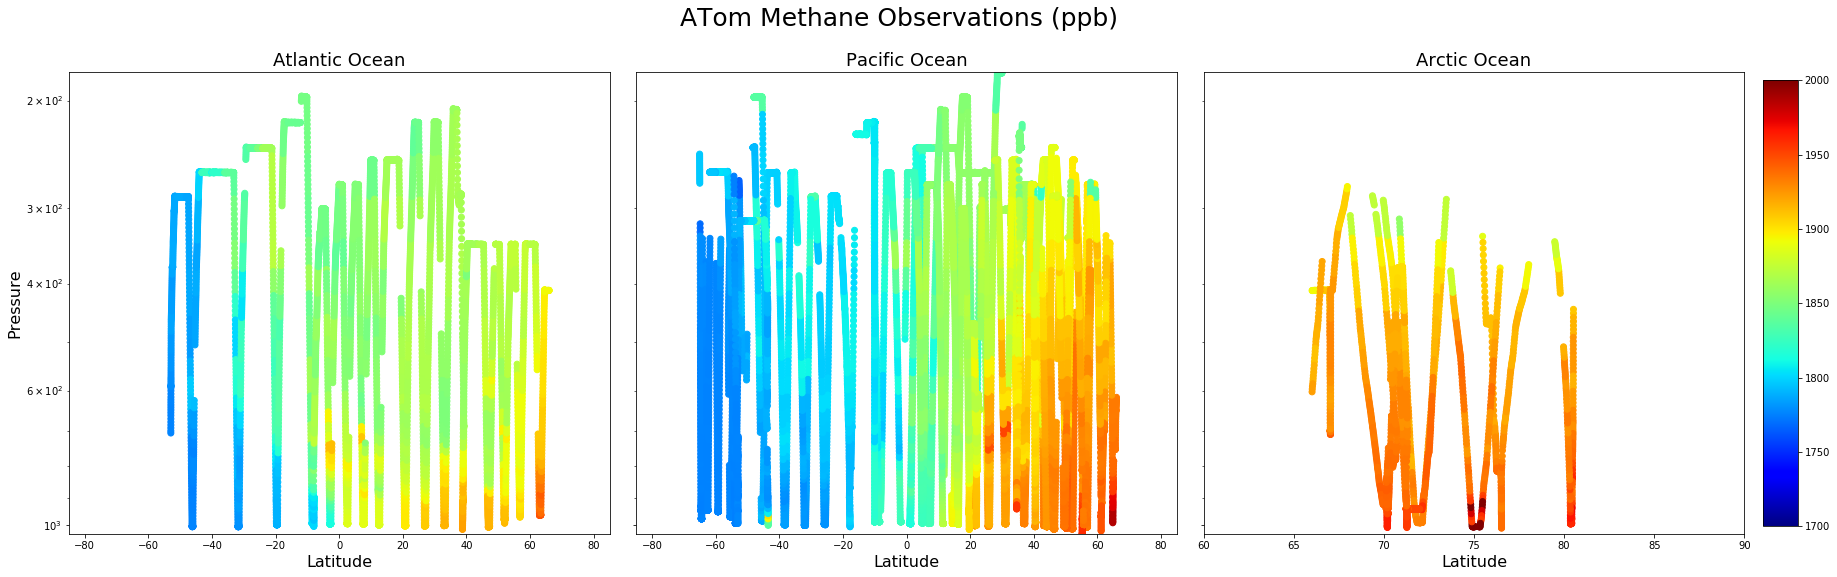

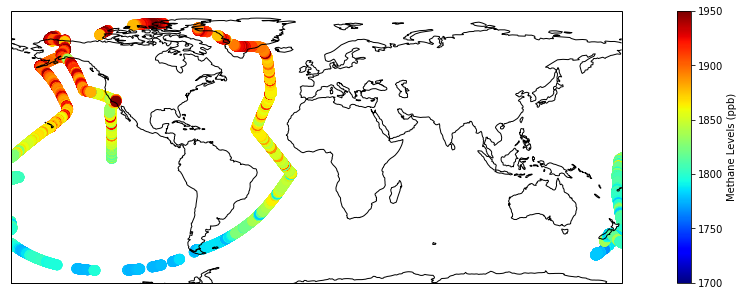

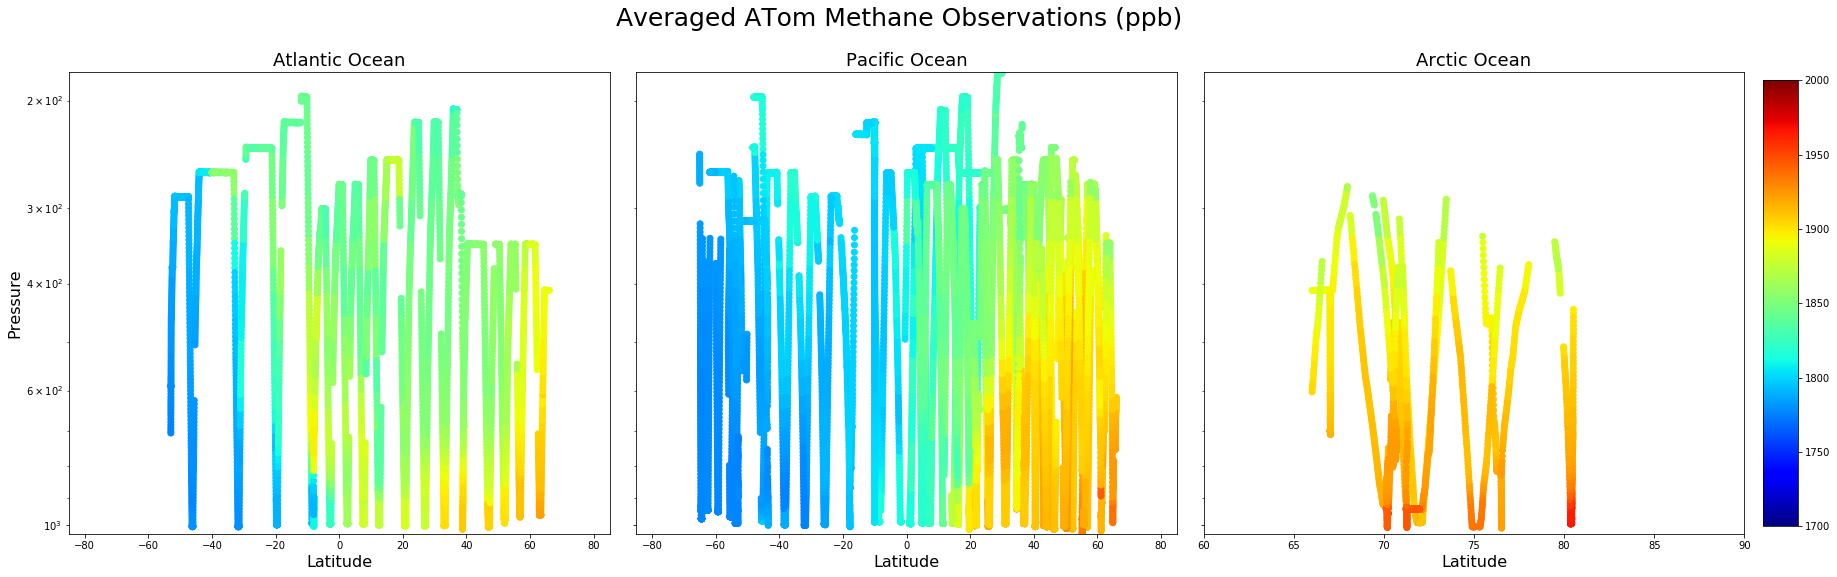

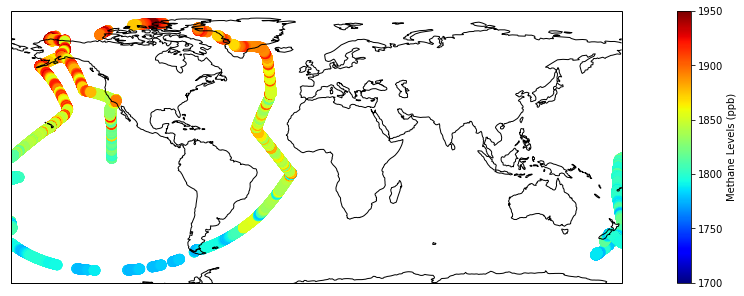

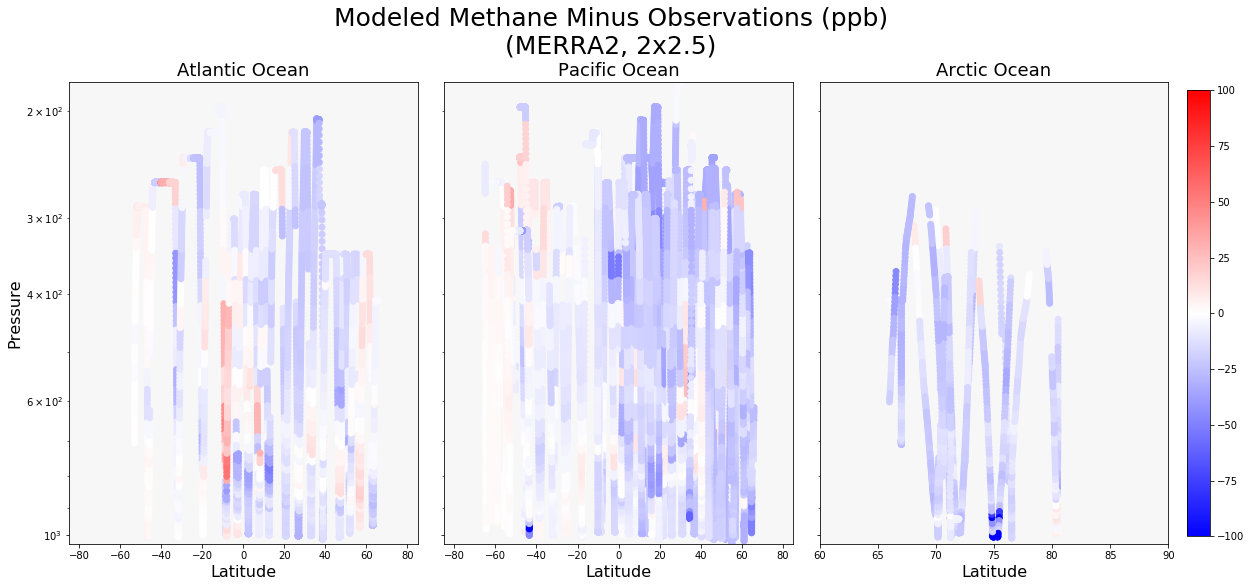

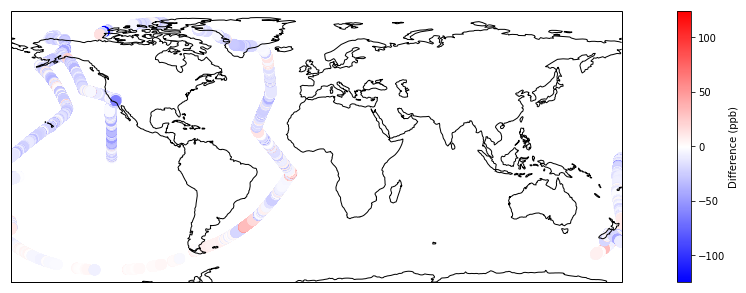

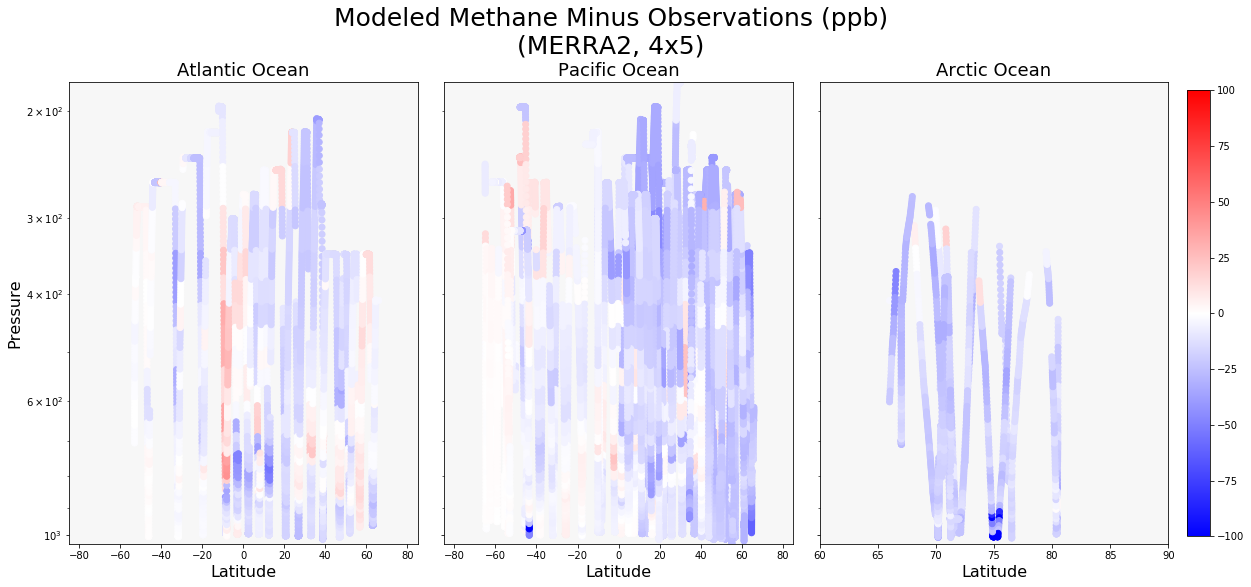

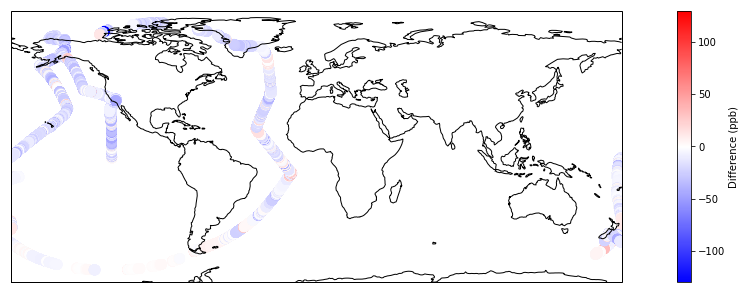

In [48]:
mr = 'M225'
data = {}
for mr, mr_data in at_tot.items():
    data[mr] = mr_data[mr_data['TYPE'] == 'ATom2']

ax = curtains.absolute_curtain(data[mr], 'OBS_AVG')
plt.suptitle('ATom Methane Observations (ppb)', fontsize=25, y=1.1)
ax = mp.heat_map(data[mr], 'OBS_AVG', 'Methane Levels (ppb)')

ax = curtains.absolute_curtain(data[mr], 'MOD')
plt.suptitle('Averaged ATom Methane Observations (ppb)', fontsize=25, y=1.1)
ax = mp.heat_map(data[mr], 'MOD', 'Methane Levels (ppb)')

ax = curtains.relative_curtain(data[mr], 'DIFF')
plt.suptitle('Modeled Methane Minus Observations (ppb)\n(MERRA2, 2x2.5)', fontsize=25, y=1.12)
ax = mp.heat_map(data[mr], 'DIFF', 'Difference (ppb)', absolute=False)

mr = 'M45'

ax = curtains.relative_curtain(data[mr], 'DIFF')
plt.suptitle('Modeled Methane Minus Observations (ppb)\n(MERRA2, 4x5)', fontsize=25, y=1.12)
ax = mp.heat_map(data[mr], 'DIFF', 'Difference (ppb)', absolute=False)

Look at difference between 2x2.5 and 4x5 model output

In [49]:
at_tot['M45']['MOD_RES_DIFF'] = at_tot['M45']['MOD']-at_tot['M225']['MOD']
pf_short['M45']['MOD_RES_DIFF'] = pf_short['M45']['MOD']-pf_short['M225']['MOD']
# changed from mod corr

Text(0.5,1.12,'Modeled Methane at 4x5 vs. 2x2.5 (ppb)\n(MERRA2, 4x5 minus 2x2.5)')

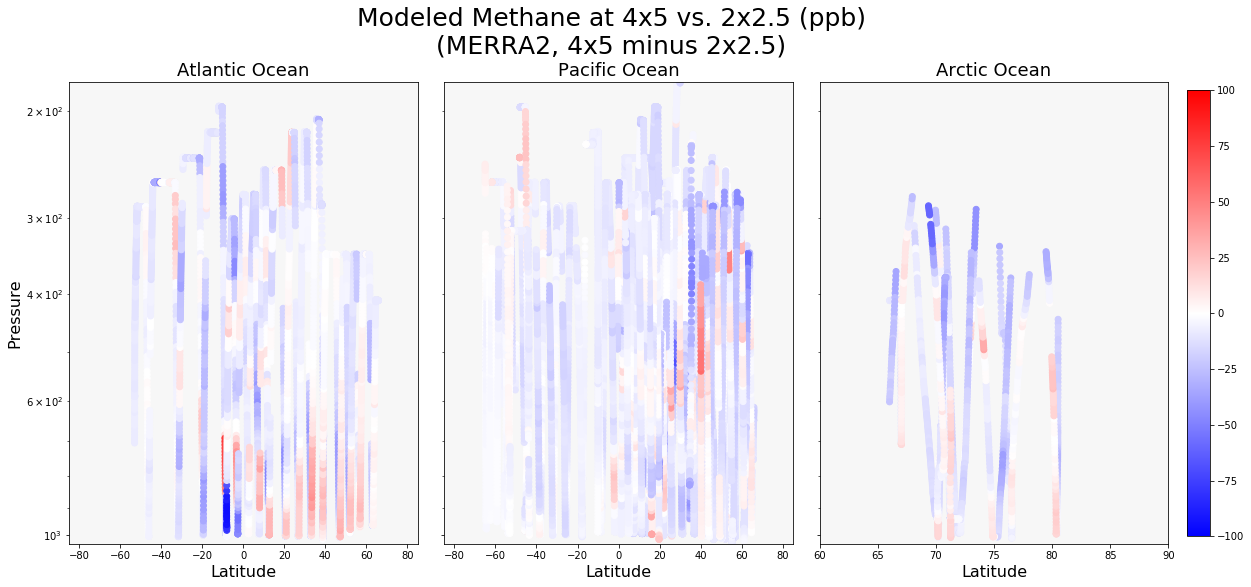

In [50]:
data = at_tot['M45'][at_tot['M45']['TYPE'] == 'ATom2']

ax = curtains.relative_curtain(data, 'MOD_RES_DIFF')
plt.suptitle('Modeled Methane at 4x5 vs. 2x2.5 (ppb)\n(MERRA2, 4x5 minus 2x2.5)', fontsize=25, y=1.12)
# ax = mp.heat_map(pf_short['M45'], 'MOD_RES_DIFF', 'Difference (ppb)', absolute=False);

In [51]:
at_tot['M45']['MOD_MET_DIFF'] = at_tot['M45']['MOD']-at_tot['G45']['MOD']
pf_short['M45']['MOD_MET_DIFF'] = pf_short['M45']['MOD']-pf_short['G45']['MOD']

Text(0.5,1.12,'Modeled Methane with MERRA2 vs GEOSFP (ppb)\n(MERRA2 minus GEOSFP, 4 x 5)')

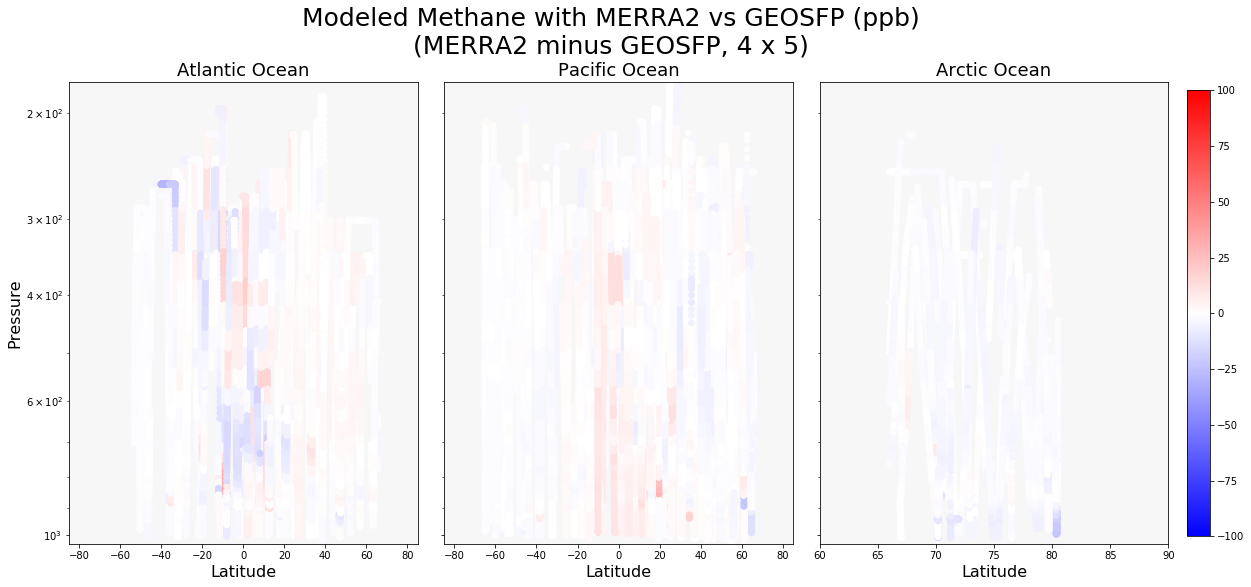

In [52]:
data = at_tot['M45'][at_tot['M45']['TYPE'] == 'ATom2']

ax = curtains.relative_curtain(at_tot['M45'], 'MOD_MET_DIFF')
plt.suptitle('Modeled Methane with MERRA2 vs GEOSFP (ppb)\n(MERRA2 minus GEOSFP, 4 x 5)', fontsize=25, y=1.12)
# mp.heat_map(pf_short['M45'], 'MOD_MET_DIFF', 'Difference (ppb)', absolute=False);